# Convolutional Neural Network to classify artifacts and stars in RoboPol images

## Dhruv Paranjpye (pdhruv@umich.edu, dhruvp@caltech.edu)


In [1]:
import json
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib
import os
import random
import imageio
import cv2


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import plot_model

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,matthews_corrcoef

Using TensorFlow backend.


## Define all the paths to data directories and obtain training data

First we define the paths to the different directories containing the training and testing images. We load all the training and testing images as lists so that it is easier to access them.

In [2]:
#Define the path to the directories containing training images and testing images 

json_file=open('input_param.json')
data = json.load(json_file) #load the json file data

train_stars_dir=data['cnn'][1] #load the path of directory containing stars training data

train_reflections_dir=data['cnn'][0] #load the path of directory containing reflections training data

test_dir=data['cnn'][2] #load the path where testing data is to be kept 

arti_test=data['cnn'][3] #load the path where artifact testing data is kept

star_test=data['cnn'][4] #load the path where star testing data is kept

challenge_data=data['challenge'][0] #load the path where challenging artfacts are kept

#Load all the training data and testing data into lists
train_stars=['./cutout/star_training/{}' .format(i) for i in os.listdir(train_stars_dir) if '.png' in i]
train_reflections=['./cutout/reflection_training/{}' .format(i) for i in os.listdir(train_reflections_dir) if '.png' in i]

test_images=['./cutout/test/{}'.format(i) for i in os.listdir(test_dir) if '.png' in i]

arti_test_image=['./cutout/test/artifacts/{}'.format(i) for i in os.listdir(arti_test) if '.png' in i]

star_test_image=['./cutout/test/stars/{}'.format(i) for i in os.listdir(star_test) if '.png' in i]

challenge_image=['./cutout/challenge/{}'.format(i) for i in os.listdir(challenge_data) if '.png' in i]


train_images=train_stars+train_reflections+challenge_image #combine training data of stars and reflections
random.shuffle(train_images) #shuffle the training data randomly
print(len(train_images)) #Check the total number of training images First we define the paths to the different directories containing the training and testing images. We load all the training and testing images as lists so that it is easier to access them.

1761


## Function to read images, pre-process images and make labels based on filenames of images

Shape of Tensor 'images' (1761, 64, 64)
Shape of Tensor 'labels ' (1761,)
Total Images with artifacts 925
Total Images with stars  836


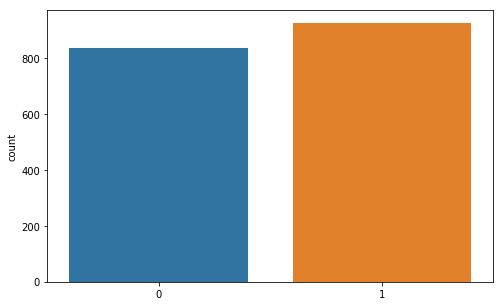

In [3]:
nx,ny,channels=64,64,1 #shape of input data. It is 64x64 pixels and 1 channel


images=[] #empty list which will be populated with images
labels=[] #empty list which will have labels.

images_name=[] #empty list containing names of all images

#Labels are either 1 or 0. 1 for artifacts, 0 for stars

def read_images(list_images): #function to generate lists of data and labels
    for img in list_images:
        
                    
        if 'cut_arti' in img: #if filename contains this string then append 1 to the labels list else 0
            images.append(cv2.resize(cv2.imread(img,0), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #i=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #i=np.rot90(i)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,i)
            #images.append(i)
            labels.append(1)
            images_name.append(img)
            #labels.append(1)

        elif 'cut_star' in img:
            
            images.append(cv2.resize(cv2.imread(img,0), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #j=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #j=np.rot90(j)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,j)
            #images.append(j)
            #labels.append(0)
            
            images_name.append(img)

            labels.append(0)
                        
    return images,labels

new_val_images=train_stars+challenge_image+train_reflections #combine training data of stars and reflections
#random.shuffle(new_val_images) #shuffle the training data randomly

new_images,new_labels=read_images(new_val_images)


new_images=np.array(new_images) # convert lists to numpy arrays. 

new_labels=np.array(new_labels) # convert lists to numpy arrays. 

l = len(new_images)


#Thus we now have a tensor images and labels. 

print("Shape of Tensor 'images'",new_images.shape) #print(images.shape,labels.shape) #shape of images and labels

print("Shape of Tensor 'labels '",new_labels.shape)
import seaborn as sns



plt.figure(figsize=(8, 5))
sns_plot=sns.countplot(new_labels) #view distribution of training data. Labels with 0 are stars, labels with 1 are artifacts

#sns_plot.figure.savefig('sns.png',dpi=200)


print("Total Images with artifacts",len(new_labels[new_labels==1]))
print("Total Images with stars ",len(new_labels[new_labels==0]))

new_images=new_images.reshape(l,64,64,1)

In [4]:
new_images.shape

(1761, 64, 64, 1)

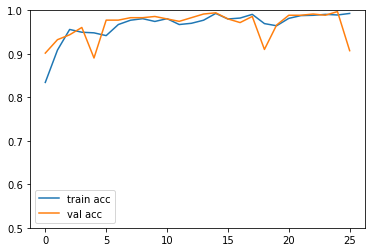

In [5]:
import matplotlib.pyplot as plt
acc_val=[0.901685393258427, 0.9325842696629213, 0.9438202247191011, 0.9606741573033708, 0.8904494382022472, 0.9775280898876404, 0.9775280898876404, 0.9831460674157303, 0.9831460674157303, 0.9859550561797753, 0.9803370786516854, 0.9747191011235955, 0.9831460674157303, 0.9915730337078652, 0.9943820224719101, 0.9803370786516854, 0.9719101123595506, 0.9859550561797753, 0.9101123595505618, 0.9662921348314607, 0.9887640449438202, 0.9887640449438202, 0.9915730337078652, 0.9887640449438202, 0.9971910112359551, 0.9073033707865169]
acc_train=[0.8342776203966006, 0.9086402266288952, 0.9560906515580736, 0.9497167138810199, 0.9483002832861189, 0.9419263456090652, 0.9674220963172805, 0.9773371104815864, 0.9808781869688386, 0.9745042492917847, 0.9808781869688386, 0.9674220963172805, 0.9702549575070821, 0.9773371104815864, 0.9929178470254958, 0.9801699716713881, 0.9822946175637394, 0.9907932011331445, 0.9695467422096318, 0.9645892351274787, 0.9815864022662889, 0.9879603399433428, 0.9886685552407932, 0.9907932011331445, 0.9893767705382436, 0.9929178470254958]
plt.ylim([0.5,1])
plt.plot(acc_train,label='train acc')
plt.plot(acc_val,label='val acc')
plt.legend()
plt.show()

## Split data into training and validation

To avoid overfitting, we split the training data into training and validation sets using the train_test_split method from the sklearn library. We choose the validation data size to be 20% of the total training data. 

In [6]:
random_state=2
#split data into training and validation data
from sklearn.model_selection import train_test_split
images_train, images_val, labels_train,labels_val=train_test_split(new_images,new_labels,test_size=0.2,random_state=random_state)  


name_train, name_val, _, _ = train_test_split(images_name,new_labels,test_size=0.2,random_state=random_state)
#random state = 2 is the seed number for generating a random number. 

ntrain=len(images_train) #length of training data
nval=len(images_val) #length of validation data


batch_size=4 # Set Batch size as 4.

print("Length of Training Data",ntrain)
print("Length of Validation Data",nval)
print("Batch Size ", batch_size)

Length of Training Data 1408
Length of Validation Data 353
Batch Size  4


In [7]:
ntrain//batch_size

352

## Define the CNN model

We have followed the commonly used Image Classification Architecture of VGG 16 for our purpose. We use a ReLU activation (Rectified Linear Unit) in each layer to ensure positive values for the pixels. A detailed description of the filter size, total filters and their types is given in the Model Summary and visualization below.




In [8]:
model2 = models.Sequential() #Creates a sequential model 
model2.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64, 64,1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.4))  #Dropout for regularization
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

model2.summary()
model2.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=1e-3), metrics=['acc'])

plot_model(model2, to_file='model2_mixed_artifacts_3conv.png')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

# Loss Function

The final activation is a sigmoid function. For clarity, a sigmoid function is used to scale inputs to between 0 or 1. This value is often the probability of the input belonging to a particular class. Why do so?

For any linear model, we use the following assumption:

Residuals are independent, normally distributed, have 0 mean and have constant variance. 

However, in case of classfication or categorical models, these assumptions do not hold. Therefore, we transform the discrete outputs using a linear function in order to find the categorical loss. 

In our case, we have 2 possible outputs. 

The sigmoid scores (output value) are found using the formula : 

$ scores = \frac{1}{1 + {\mathrm{e}{-x}}} $

where x is the input to the sigmoid function 


The Binary Cross Entropy Loss for N images is calculated using the formula :

$$ loss = \sum_{i=1}^N -y[i] * log(scores[i]) - (1 - y[i]) * log(1 - scores[i]) $$

where i is the image number, y[i] is the label for the ith image and
scores[i] is the sigmoid score for the ith image

# Prepare Data Generators for Augmenting Data

# Data Augmentation
Note that although the total number of our training images is about 900 that is low for training any CNN. Therefore we want to augment the size of our dataset. To do so, we use the ImageDataGenerator class which helps us to perform scaling, rotate, flip and other image operations on our images to augment the dataset.

Note that we normalize the images by 255 so that all pixels have a value between 0 and 1. 

We also perform random rotations and shifts of the images so that we can consider the possibility of the artifact or star not being at the exact center of the 64 x 64 pixel box. This better helps us to have a robust dataset. Furthermore, we also perform horizontal and vertical flips to augment the data. The purpose of data augmentation is to reduce the number of random correlations that exist between the images and increase the data set size. This helps in reducing overfitting problems.

Note that data augmentation is not done for validation/testing data. We only normalize the pixels in testing/validation images.

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True, vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

train_generator = train_datagen.flow(images_train, labels_train, batch_size=batch_size) 
val_generator = val_datagen.flow(images_val, labels_val, batch_size=batch_size)


# Define Class to help plot live training curves

In [12]:
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

# Train the Model and save the model and its weights

In [ ]:

#history = model2.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=100,
                              callbacks=[plot],
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

In [ ]:
#import pickle
#with open('models/adam/trainHistoryDict_model2.txt', 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)


#with open('models/adam/trainHistoryDict_model2..json', 'w') as f:
#    json.dump(history.history, f)


In [ ]:
#model2.save_weights('models/adam/weights_model2.h5') #save the weights of the model
#model2.save('models/adam/model2.h5') #save the model

# Load the model and its weights

In [13]:
from keras.models import load_model
model2=load_model('models/adam/model2.h5') #load model
model2.load_weights('models/adam/weights_model2.h5') #load model weights

In [15]:
train_history=open('models/adam/trainHistoryDict_model2..json','r')
file=train_history.readlines()
for line in file:
    line=line.split()
    
acc = history.history['acc'] #accuracy history
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')

plt.legend()
#plt.savefig('training_validation_plots_model9.png',dpi=300,format='png')

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
#plt.savefig('training_validation_loss_model9.png',dpi=300,format='png')

plt.show()


NameError: name 'history' is not defined

# Predict Model on validation data 

In [14]:
l=0
yhat=[] #empty list to which we append predicted label
probl=[] #empty list to which we append probability of prediction

# Loop through the images in validation data with batch size 1 and predict on each

for batch in val_datagen.flow(images_val,batch_size=1,shuffle=False):
    
    pr=model2.predict(batch)
    probl.append(pr)
    #If prediction is greater than 0.5 then mark as star else artifact
    if pr<0.5:
        yhat.append(0) #label 0 for star
    else:
        yhat.append(1) #label 1 for artifact
        
    l+=1
    if(l==len(images_val)):
        break
    

# Confusion Matrix and ROC curve analysis on Validation Data


[[170   3]
 [  5 175]]
F1 Score is :  0.9776536312849161
Matthews Correlation Coefficient 0.9547278979989932
Recall is :  0.9722222222222222
Precision score is :  0.9831460674157303
Area under curve is  0.9962427745664739
[2.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 9.312e-01
 9.297e-01 6.470e-01 6.333e-01 6.187e-01 6.079e-01 5.122e-01 3.159e-01
 2.015e-01 1.895e-01 1.852e-01 1.484e-01 7.617e-02 5.585e-02 4.581e-02
 2.440e-04 2.334e-04 0.000e+00]
[0.      0.      0.      0.      0.      0.      0.      0.00578 0.00578
 0.01156 0.01156 0.01733 0.01733 0.02312 0.02312 0.0289  0.0289  0.03467
 0.03467 0.05203 0.05203 0.3064  0.3064  1.     ]
[0.     0.1055 0.1111 0.1278 0.15   0.1722 0.778  0.778  0.9556 0.9556
 0.961  0.961  0.972  0.972  0.9775 0.9775 0.9834 0.9834 0.989  0.989
 0.9946 0.9946 1.     1.    ]


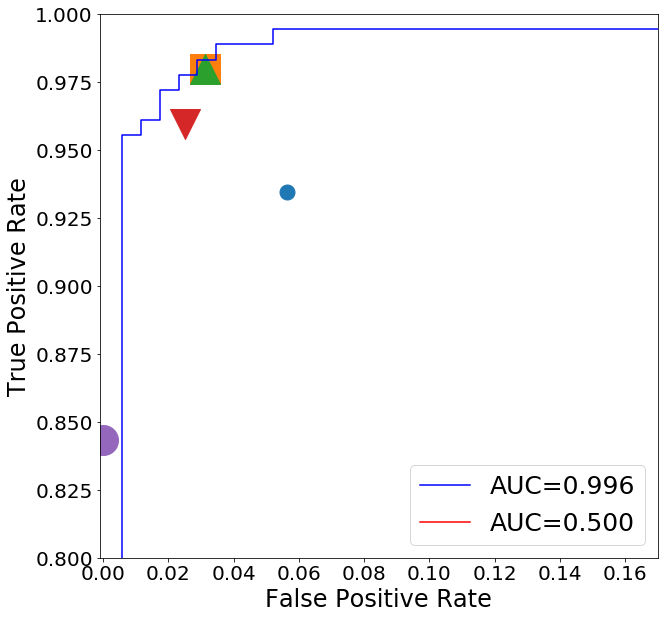

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score,auc
import scikitplot as skplt


conf=confusion_matrix(labels_val,yhat) 
print(conf) #Print confusion Matrix
print("F1 Score is : ",f1_score(labels_val,yhat))
print("Matthews Correlation Coefficient",matthews_corrcoef(labels_val,yhat))
print("Recall is : ",recall_score(labels_val,yhat))
print("Precision score is : ",precision_score(labels_val,yhat))

probl=np.array(probl) #make numpy array of list probl
yhat=np.array(yhat) #make numpy array of list yhat
probl=probl.flatten() #prepare the numpy array so that it is in valid format for roc_auc_score function

roc_sc=roc_auc_score(labels_val,probl) #Finding Area under curve of ROC
print("Area under curve is ",roc_sc)

plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 25
fpr, tpr, thresholds = roc_curve(labels_val,probl)
plt.plot(fpr,tpr,'b')
plt.plot(fpr,fpr,'r')
s=900
plt.scatter(0.05624,0.9346,label='Threshold: 0.2',marker='.',s=s)
plt.scatter(0.03125,0.9797,label='Threshold: 0.5',marker=',',s=s)
plt.scatter(0.03125,0.98,label='Threshold: 0.75',marker='^',s=s)
plt.scatter(0.025,0.9595,label='Threshold: 0.9',marker='v',s=s)
plt.scatter(0,0.8433,label='Threshold: 0.99',marker='o',s=s)
plt.ylim(0.8,1)
plt.xlim(-0.001,0.17)

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['AUC=0.996','AUC=0.500'])
#plt.savefig('ROC_cuve_zoom_jpg.png',dpi=150)

print(np.array(thresholds,dtype='float16'))
print(np.array(fpr,dtype='float16'))
print(np.array(tpr,dtype='float16'))

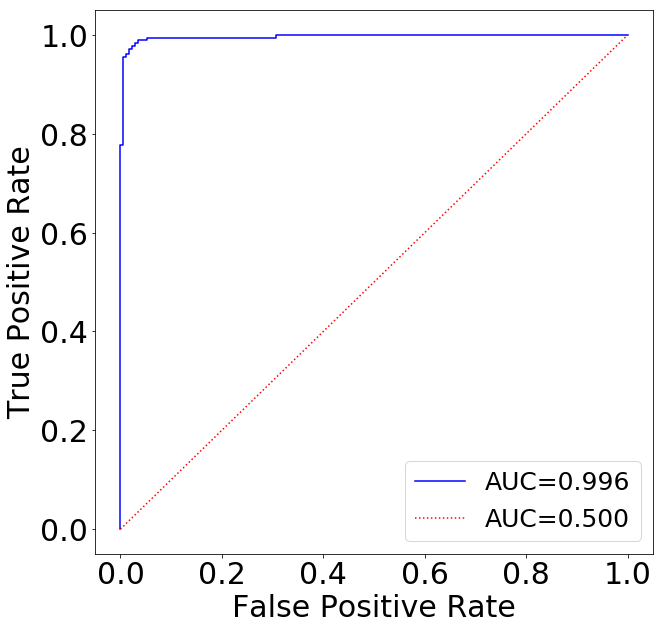

In [16]:
plt.rcParams["axes.labelsize"]=30
plt.rcParams["xtick.labelsize"]=30
plt.rcParams["ytick.labelsize"]=30
roc_auc = auc(fpr, tpr) # compute area under the curve
plt.plot(fpr, tpr,'b-',label='AUC=0.996',)
plt.plot([0, 1], [0, 1], 'r:',label='AUC=0.500')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="best")
plt.show()
#plt.savefig('rocnew.jpg',dpi=100)

plt.close()

Confusion matrix, without normalization
[[170   3]
 [  5 175]]
Normalized confusion matrix
[[0.98 0.02]
 [0.03 0.97]]


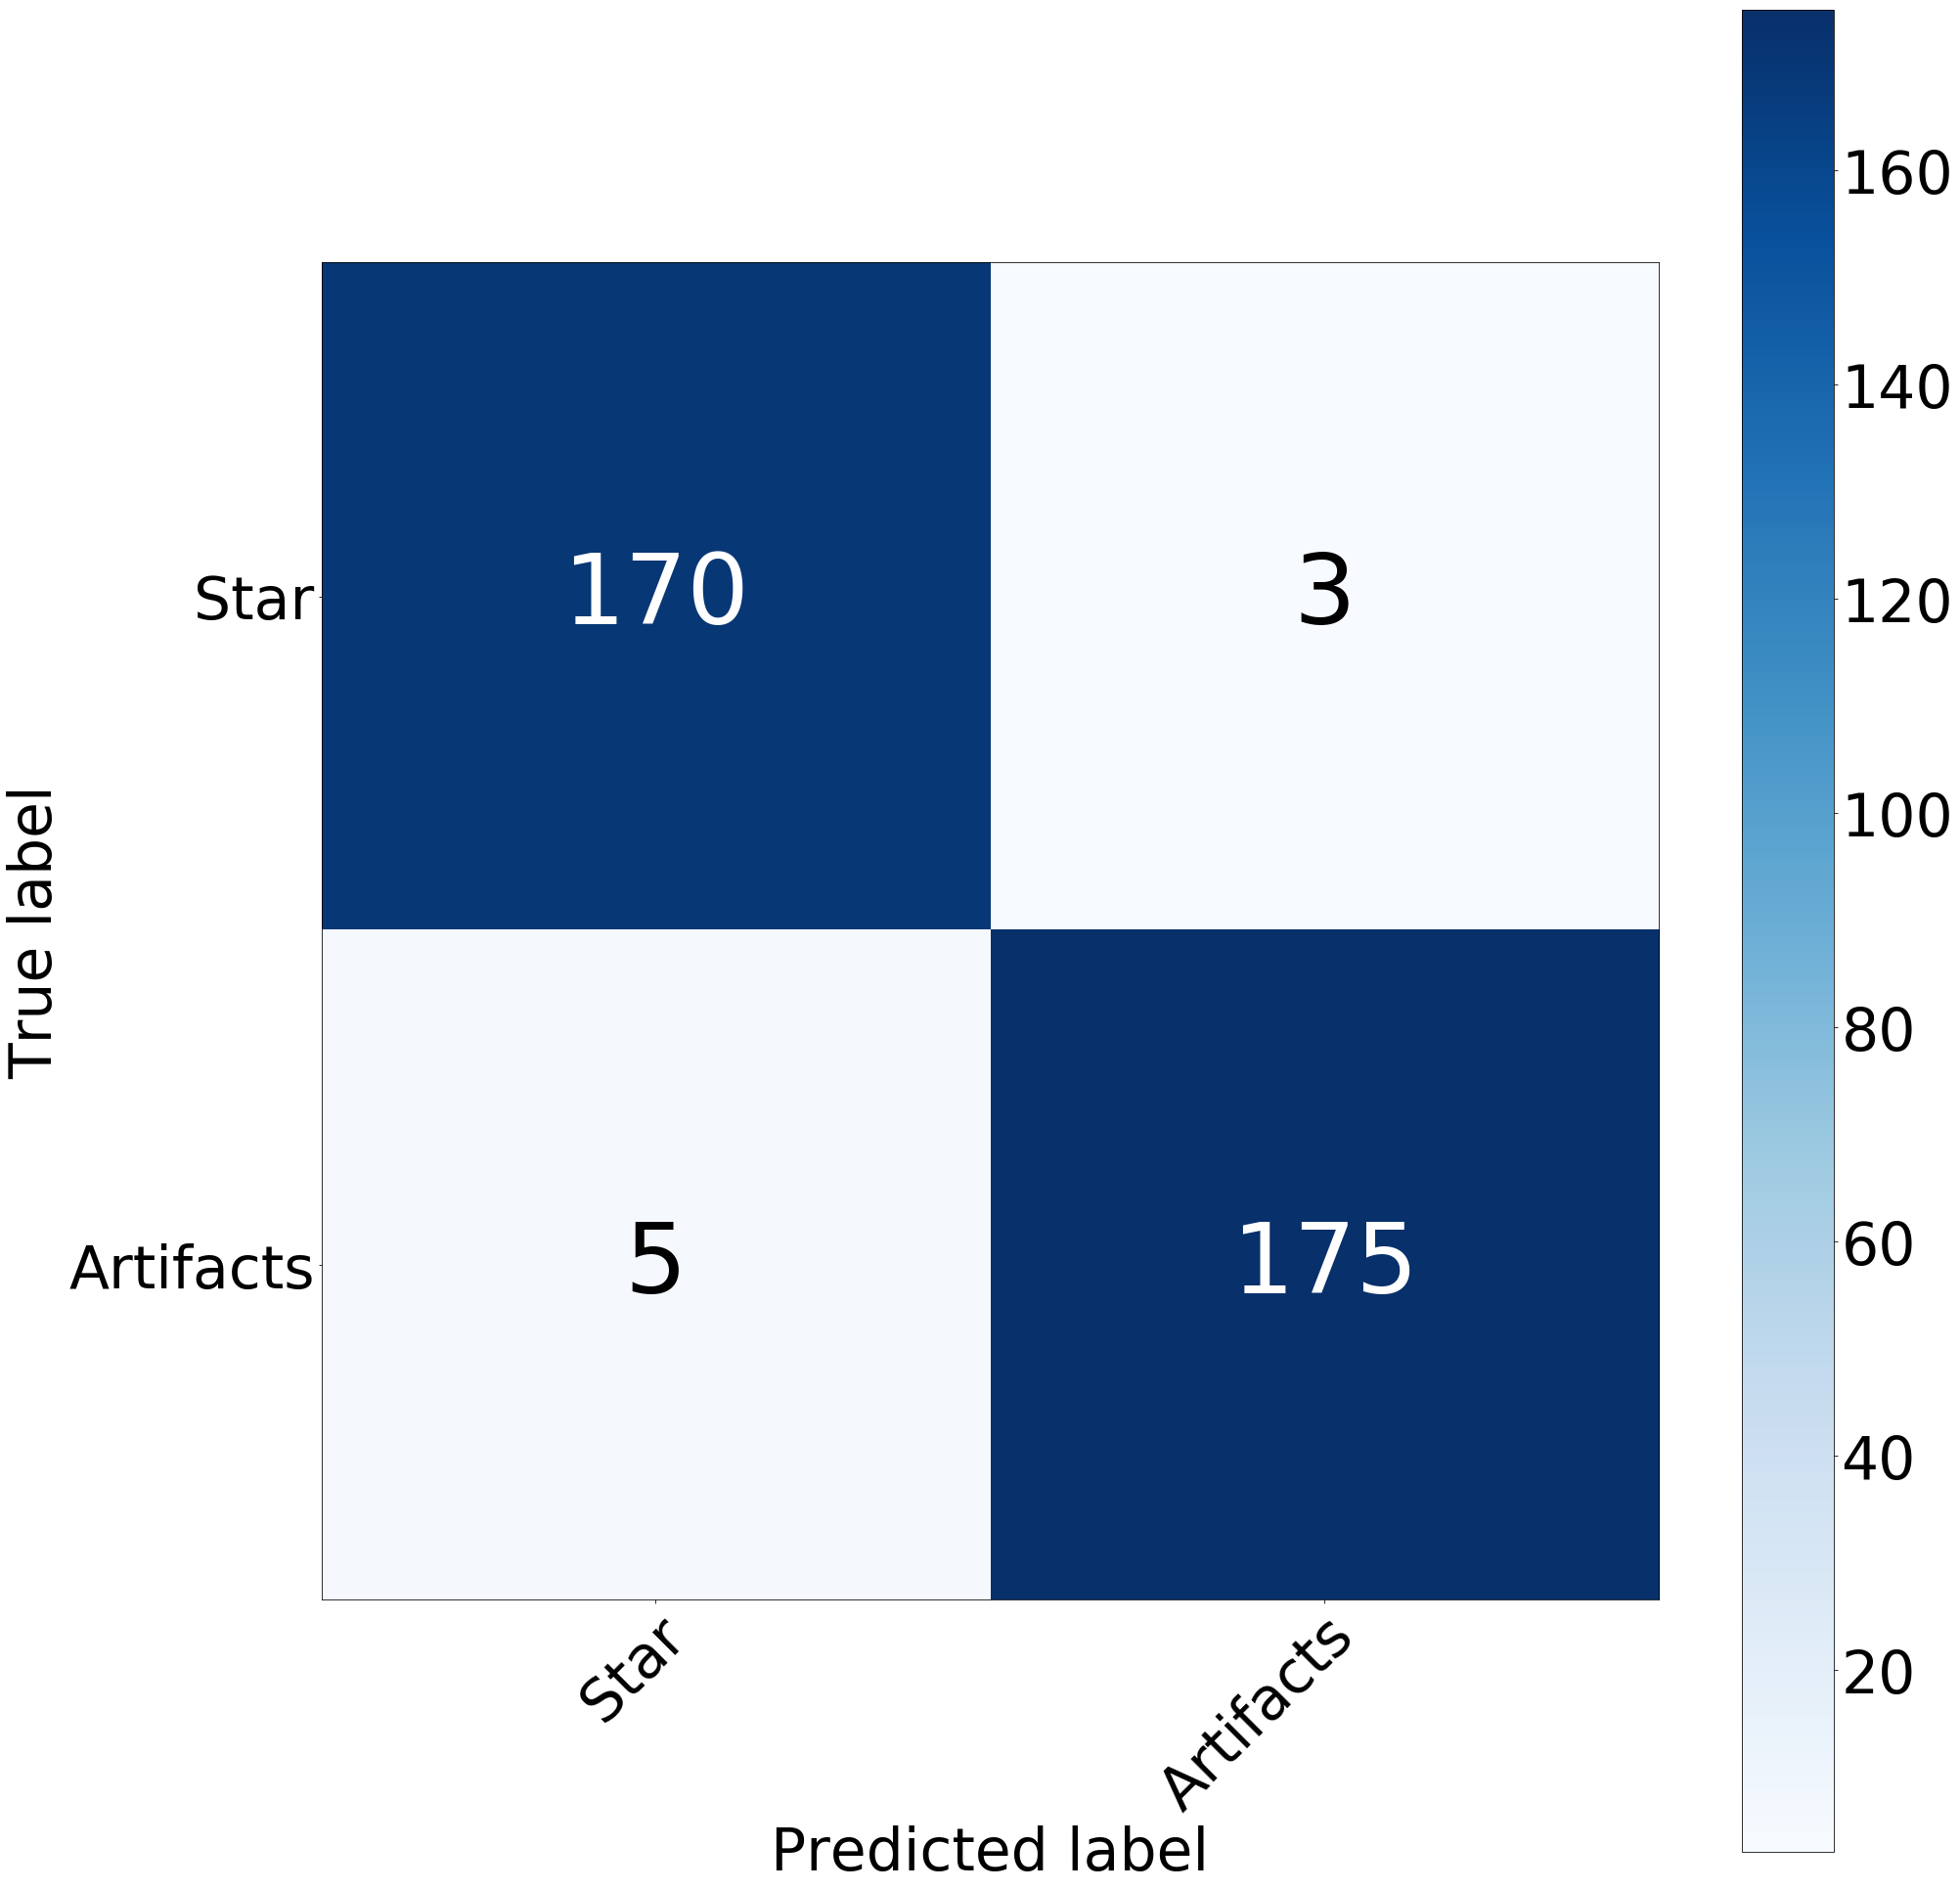

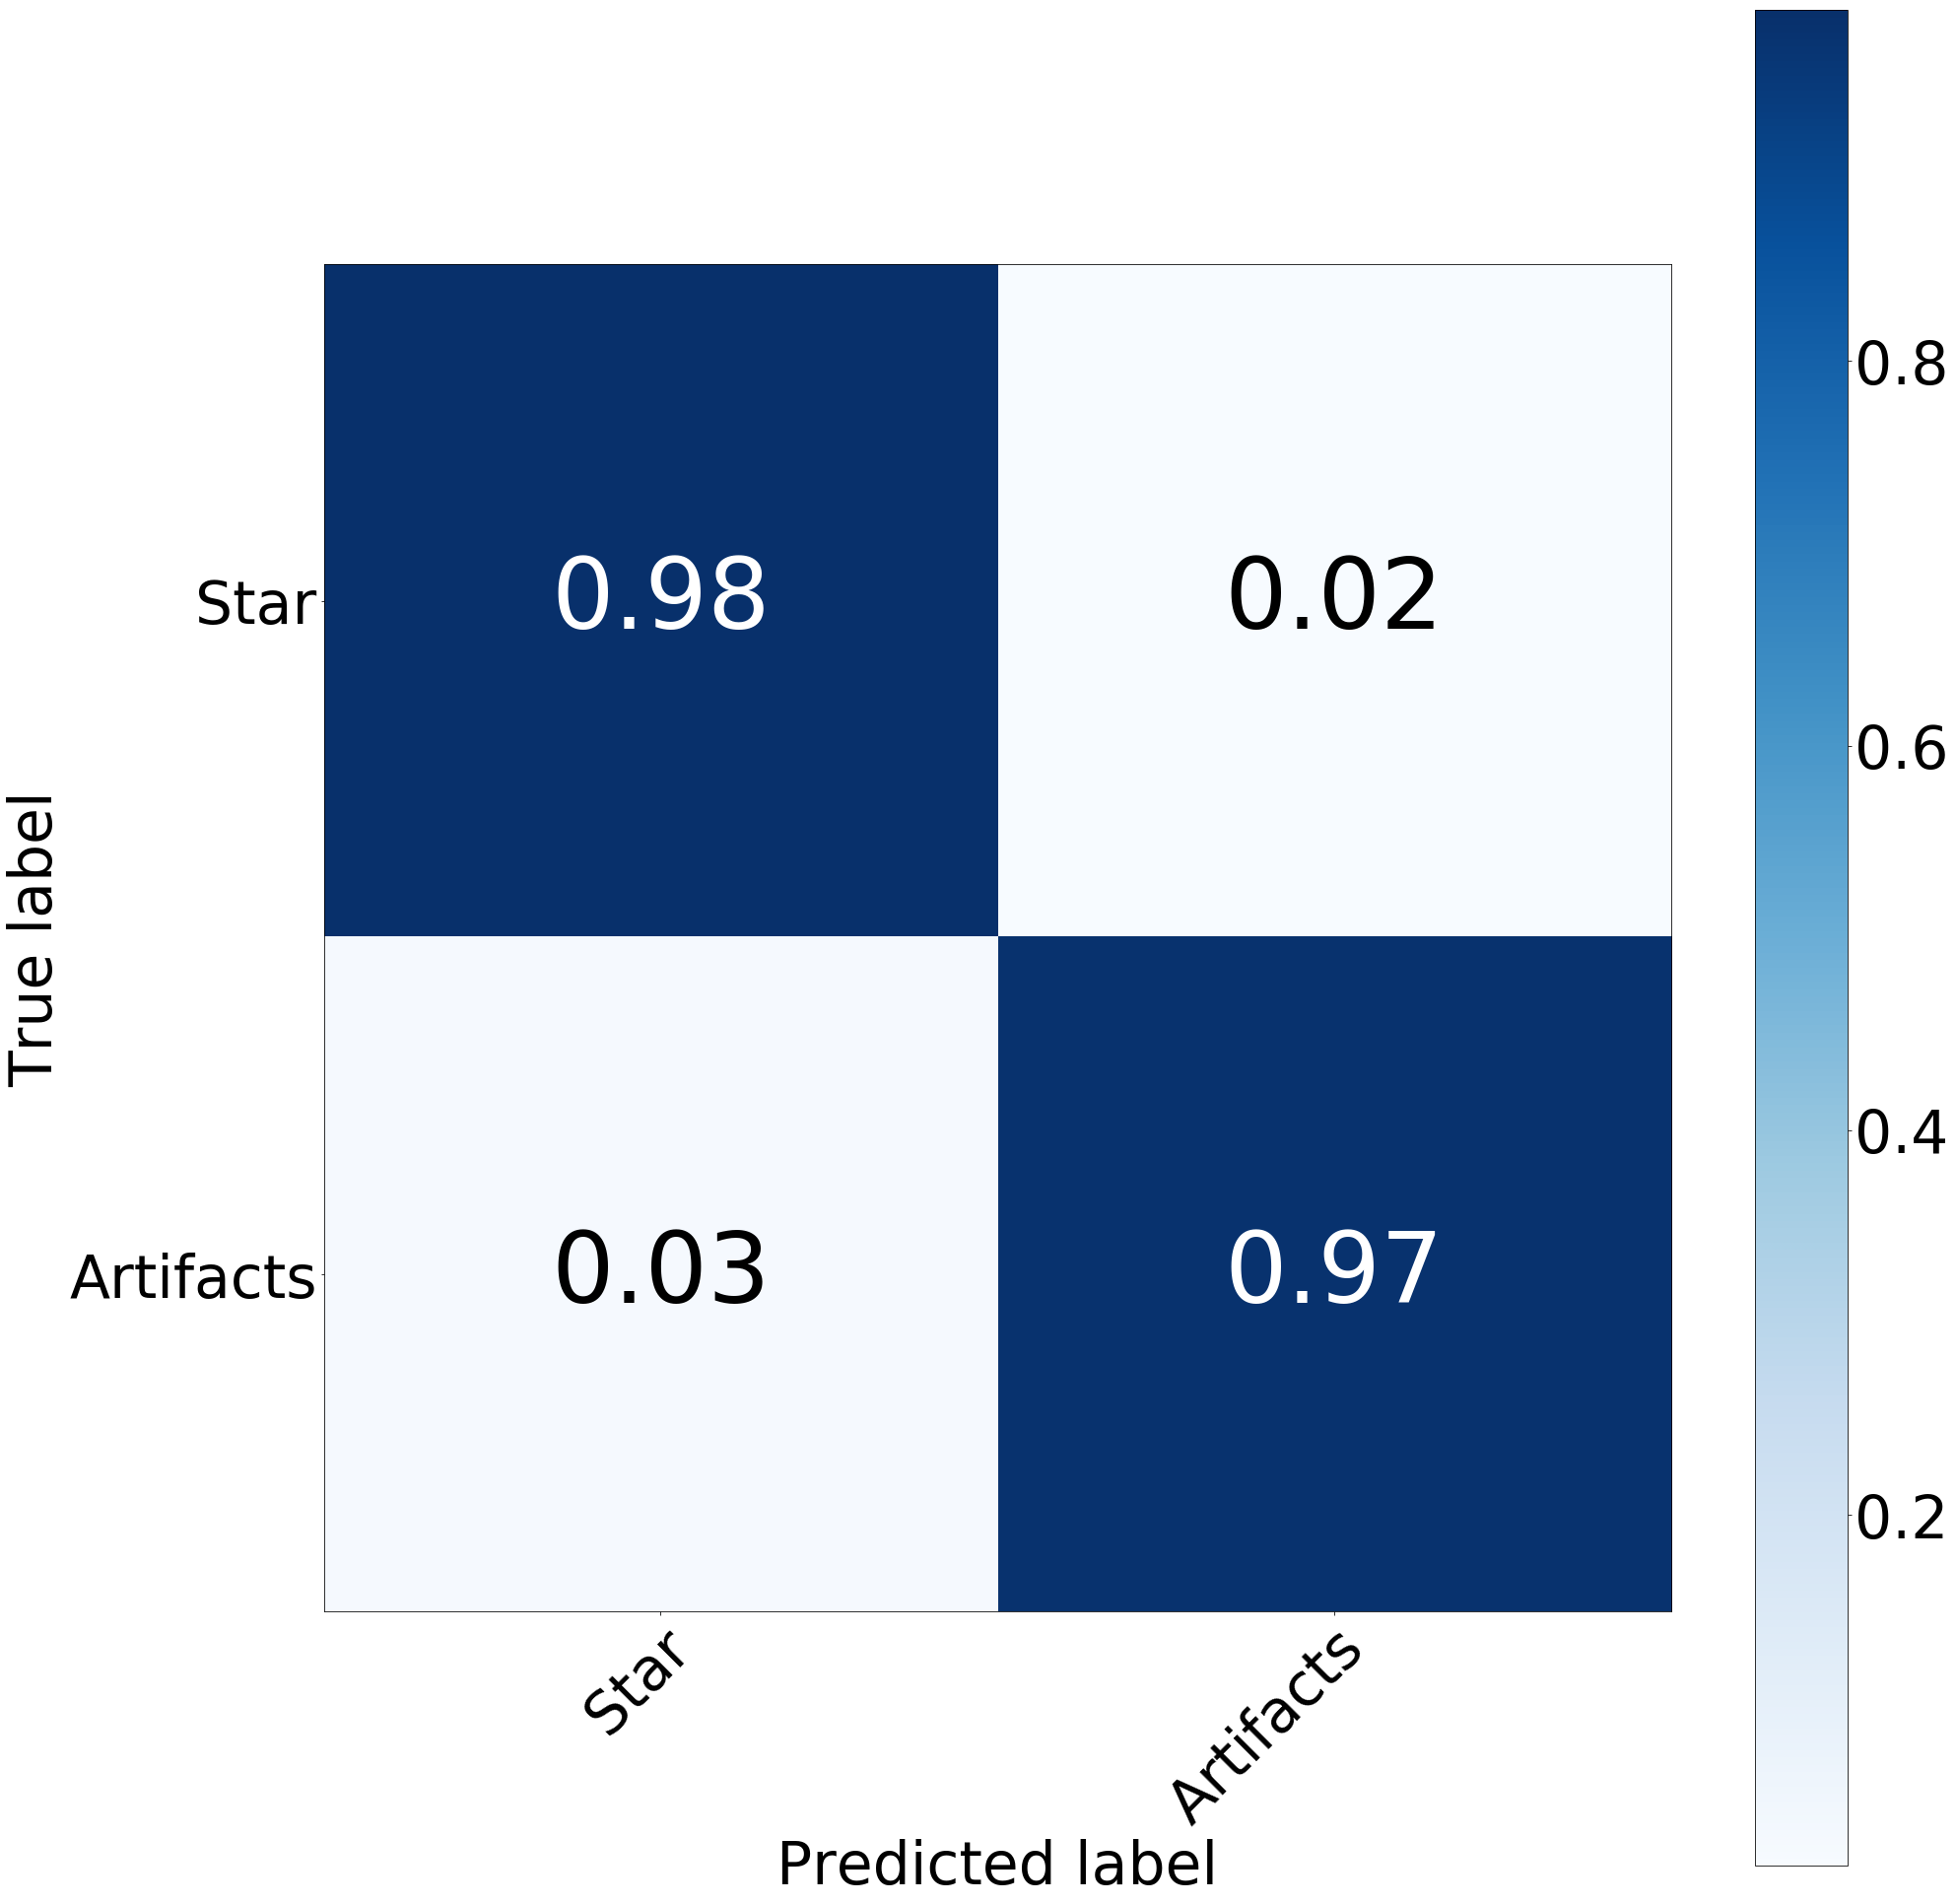

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
class_names = np.array(['Star','Artifacts'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    plt.rcParams["font.size"] = "60"
    plt.rcParams["figure.figsize"] = "30,30"
    plt.rcParams["axes.labelsize"] = "60"
    plt.rcParams["xtick.labelsize"] = "60"
    plt.rcParams["ytick.labelsize"] = "60"
    plt.rcParams["axes.labelsize"] = "60"
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = ''
        else:
            title = ''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    ax.fontsize=100
    ax.titlesize=50
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.fontsize=60
    ax.figure.colorbar(im, ax=ax)

        # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),fontsize=100,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels_val, yhat,classes=class_names,
                      title='')
plt.savefig('models/confusion_matrix_3conv.png',dpi=200)

# Plot normalized confusion matrix
plot_confusion_matrix(labels_val, yhat,classes=class_names, normalize=True)
#                      title='Normalized confusion matrix')
plt.savefig('models/normalized_confusion_matrix_3conv.png',dpi=200)

plt.show()


plt.rcParams["font.size"] = "10"
plt.rcParams["figure.figsize"] = "10,10"
plt.rcParams["axes.labelsize"] = "10"
plt.rcParams["xtick.labelsize"] = "10"
plt.rcParams["ytick.labelsize"] = "10"
plt.rcParams["axes.labelsize"] = "10"

## Disclaimer: Please note that originally the labels were '1' for artifact and '0' for star. We later reversed them in our plots and figures for the paper for scientific uniformilty. Therefore, the program still considers a '1' for an artifact and '0' for a star. 

In [18]:
#Small function to append the total number of true and false 
#negatives and positives 
def perf_measure(y_actual, y_hat):
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(len(y_hat)): 
        
        if y_actual[i]==y_hat[i]==1:
            TP.append(i)
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP.append(i)
        if y_actual[i]==y_hat[i]==0:
            TN.append(i)
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN.append(i)

    return(TP, FP, TN, FN)


tp,fp,tn,fn=perf_measure(labels_val,yhat)

# True Positives

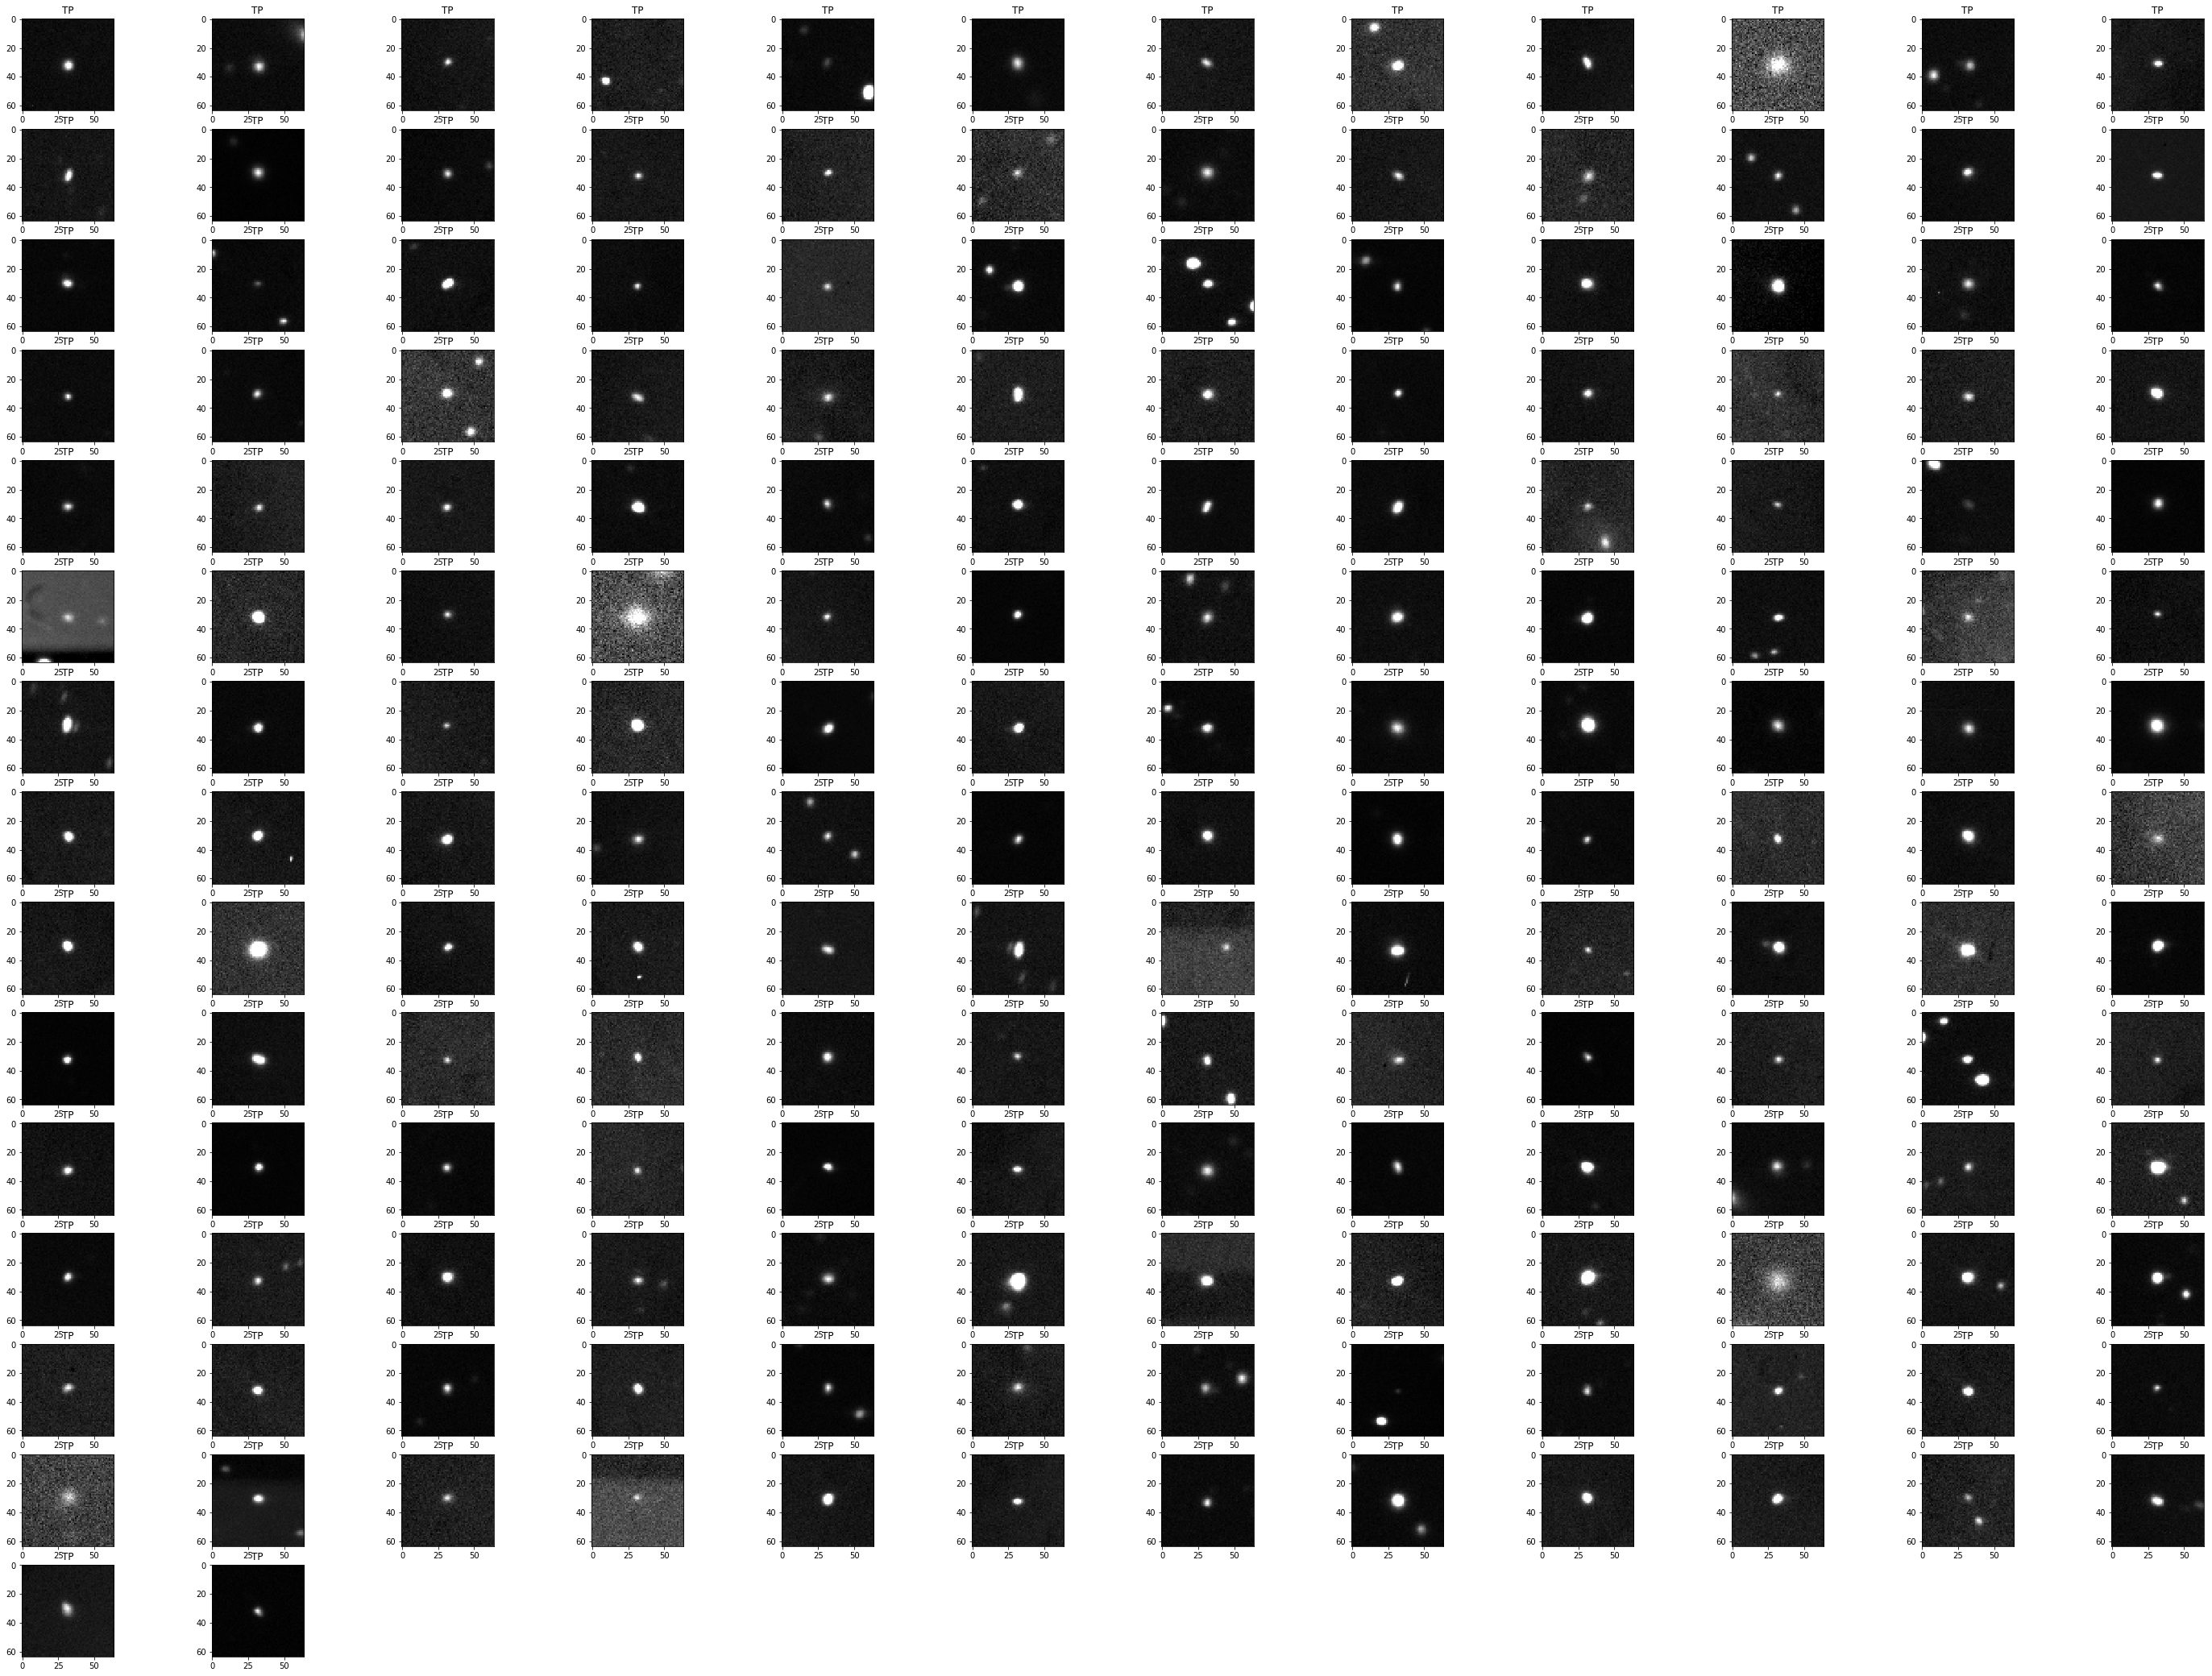

In [19]:
plt.figure(figsize=(50,50))


for i in range(conf[0][0]):
    
    plt.subplot(20,12,i+1)
    k=tn[i]
    temp = np.reshape(images_val[k],(64,64))
    plt.imshow(temp,cmap='gray')
    plt.title('TP')
#plt.savefig('TN.png',format='png',dpi=500)

# True Negatives

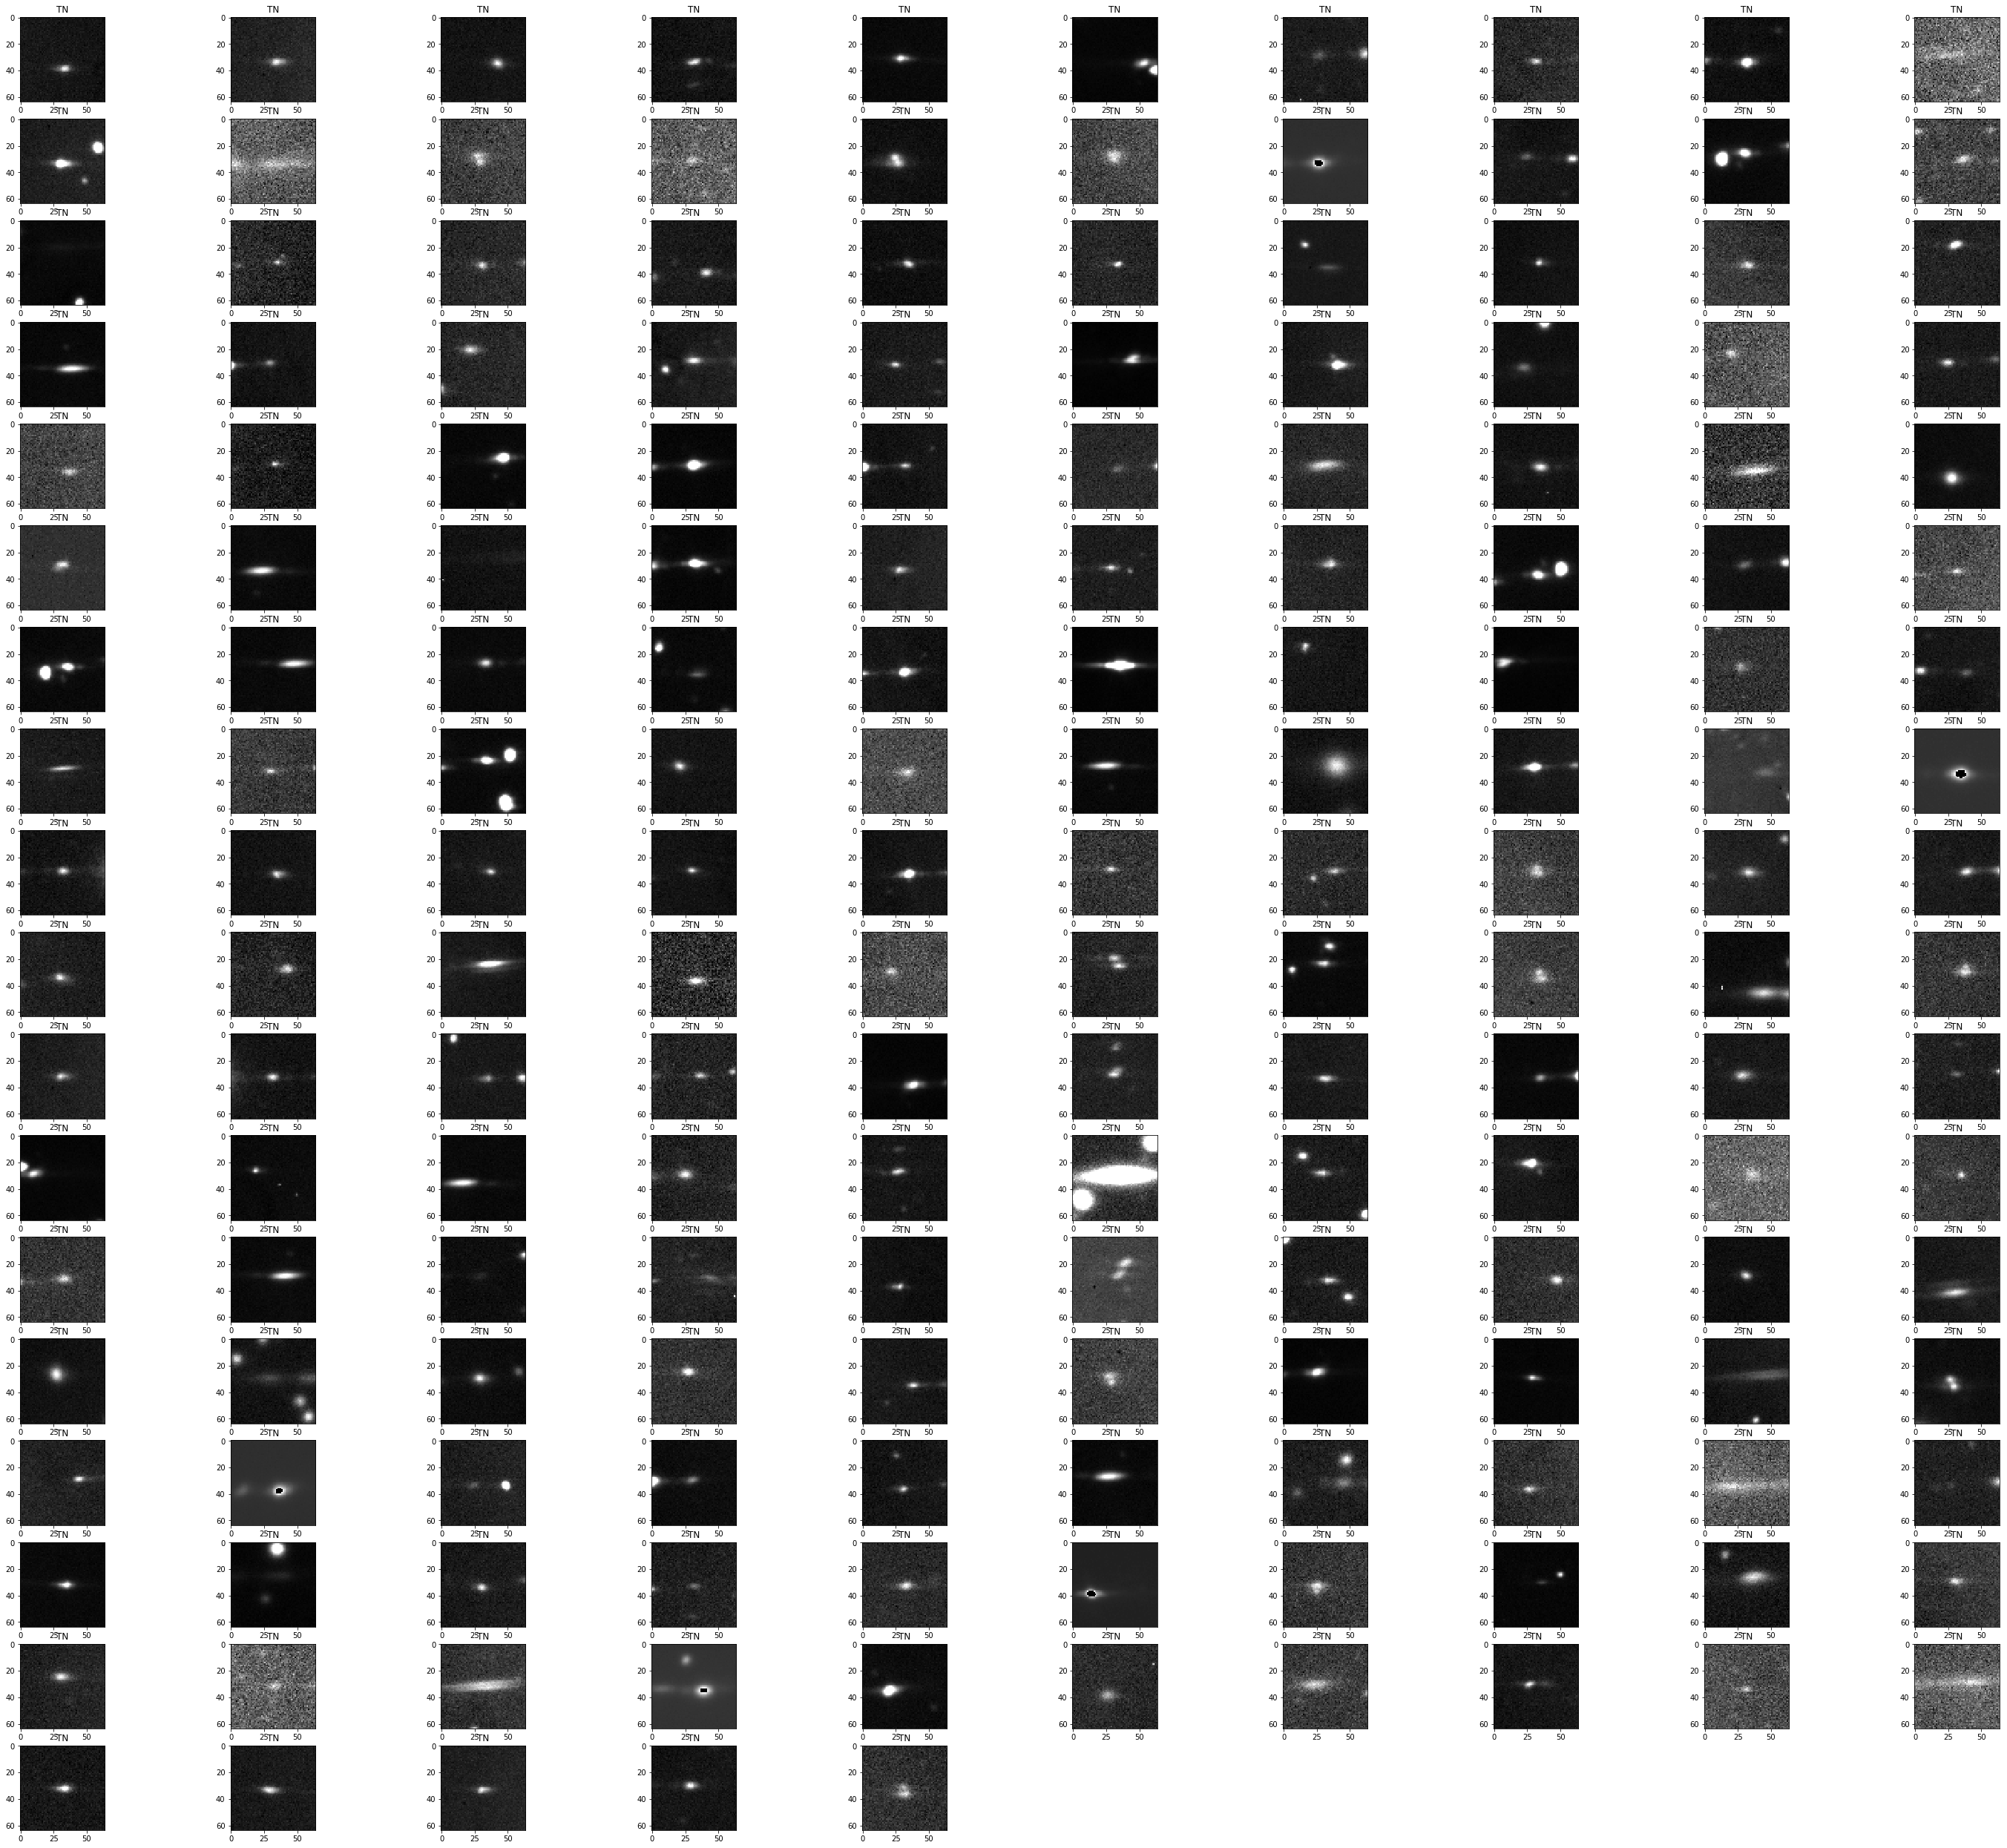

In [20]:
plt.figure(figsize=(50,50))


for i in range(conf[1][1]):
    
    plt.subplot(20,10,i+1)
    k=tp[i]
    temp = np.reshape(images_val[k],(64,64))
    plt.imshow(temp,cmap='gray')
    plt.title('TN')
#plt.savefig('TP.png',dpi=300,format='png')

# False Positives

./cutout/reflection_training/cut_arti_2_RBPLJ1551+5806_02_R_297.00_2013_10_06-17_50_06._499_1489_rot180.png
./cutout/challenge/cut_arti_14_RBPLJ1927+7358_00_R_96.00_2014_08_27-22_04_38._1453_153.png
./cutout/reflection_training/cut_arti_2_RBPLJ1542+6129_02_R_200.00_2013_07_19-22_14_27._1509_96.png
./cutout/challenge/cut_arti_9_RBPLJ1542+6129_00_R_122.00_2014_06_14-21_13_25._1519_116_rot180.png
./cutout/challenge/cut_arti_3_RBPLJ1604+5714_00_R_200.00_2013_10_06-18_05_21._279_1993_rot180.png


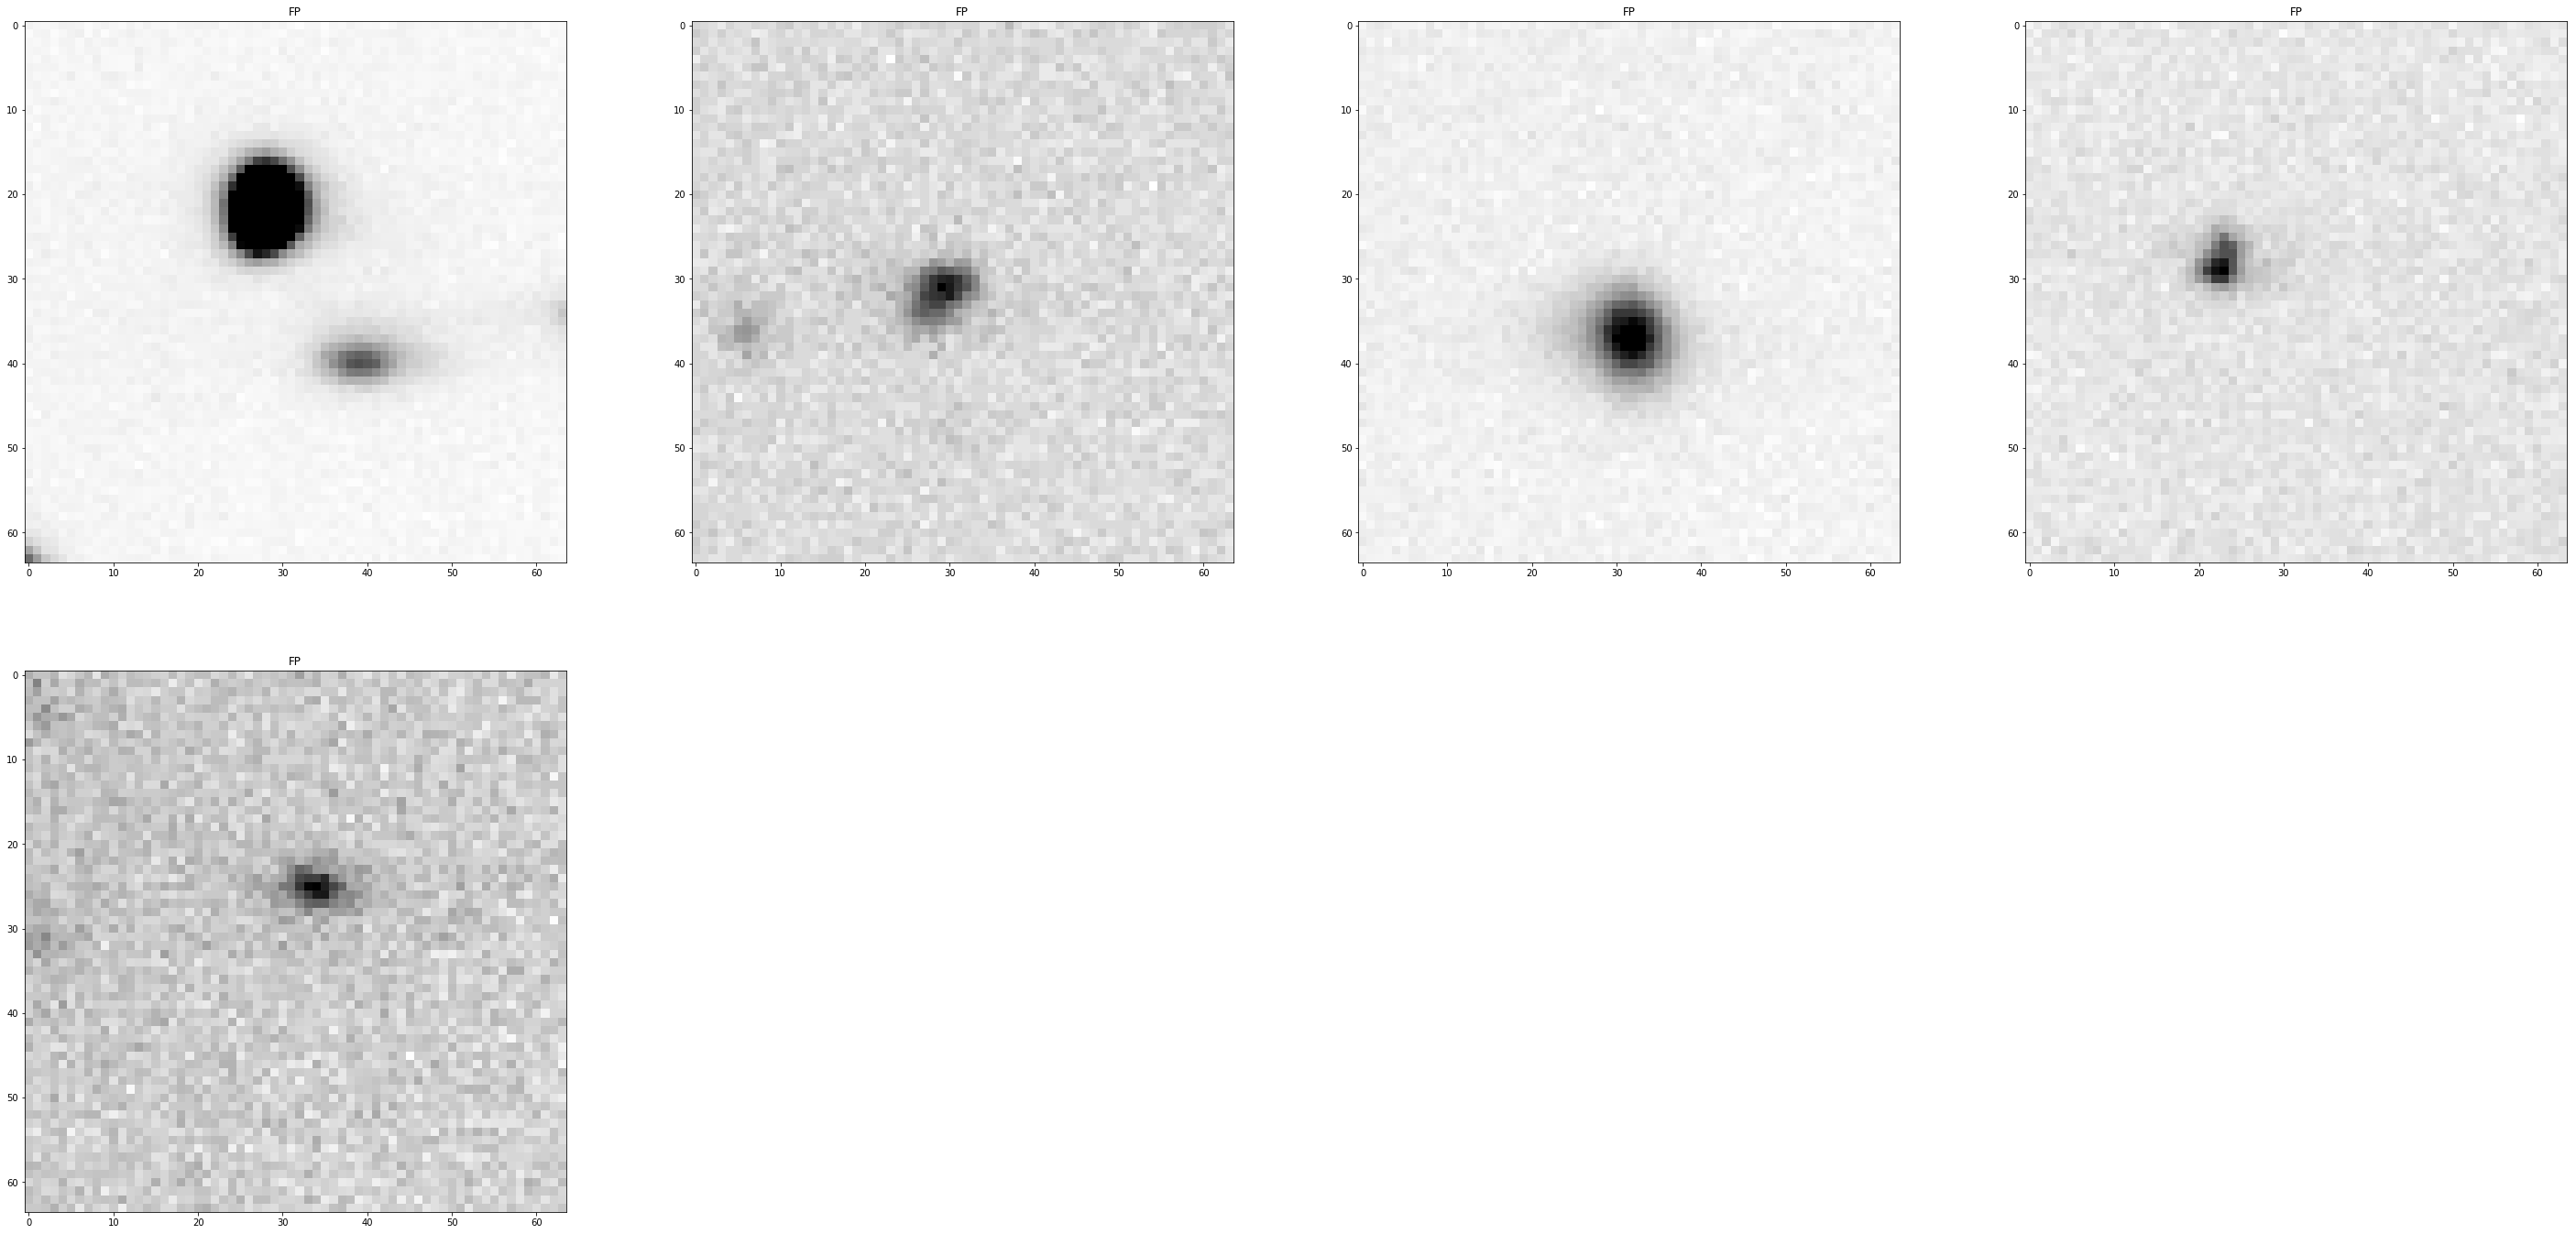

In [21]:
plt.figure(figsize=(50,50))


for i in range(conf[1][0]):
    
    plt.subplot(4,4,i+1)
    k=fn[i]
    temp = np.reshape(images_val[k],(64,64))
    print(name_val[k])
    plt.imshow(temp,cmap='gray_r')
    plt.title('FP')
#plt.savefig('FN.png',dpi=300,format='png')    

# False Negatives

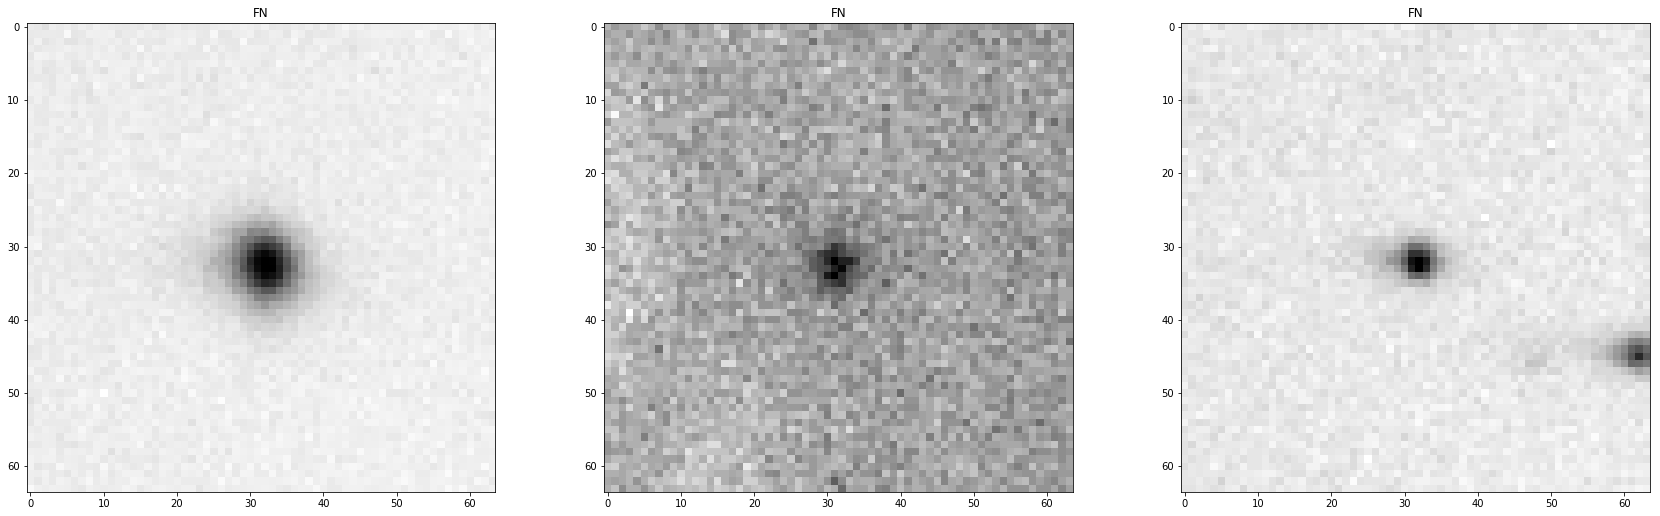

In [22]:
plt.figure(figsize=(50,50))


for i in range(conf[0][1]):
    
    plt.subplot(5,5,i+1)
    k=fp[i]
    temp = np.reshape(images_val[k],(64,64))

    plt.imshow(temp,cmap='gray_r')
    plt.title('FN')
#plt.savefig('FP.png',dpi=200,format='png')       

## Visualization with Saliency Maps

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model2.layers]) 
#we make a dictionary of the layers in the model


layer_dict

{'conv2d_2': <keras.layers.convolutional.Conv2D at 0x1a3e4fefd0>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x1a3e4fe198>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x1a3a301ef0>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x1a3809c518>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x1a3e4fe390>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x1a3a305fd0>,
 'flatten_1': <keras.layers.core.Flatten at 0x1a3809c198>,
 'dropout_1': <keras.layers.core.Dropout at 0x10a588b70>,
 'dense_1': <keras.layers.core.Dense at 0x10a588c18>,
 'dense_2': <keras.layers.core.Dense at 0x10a5a4e48>}

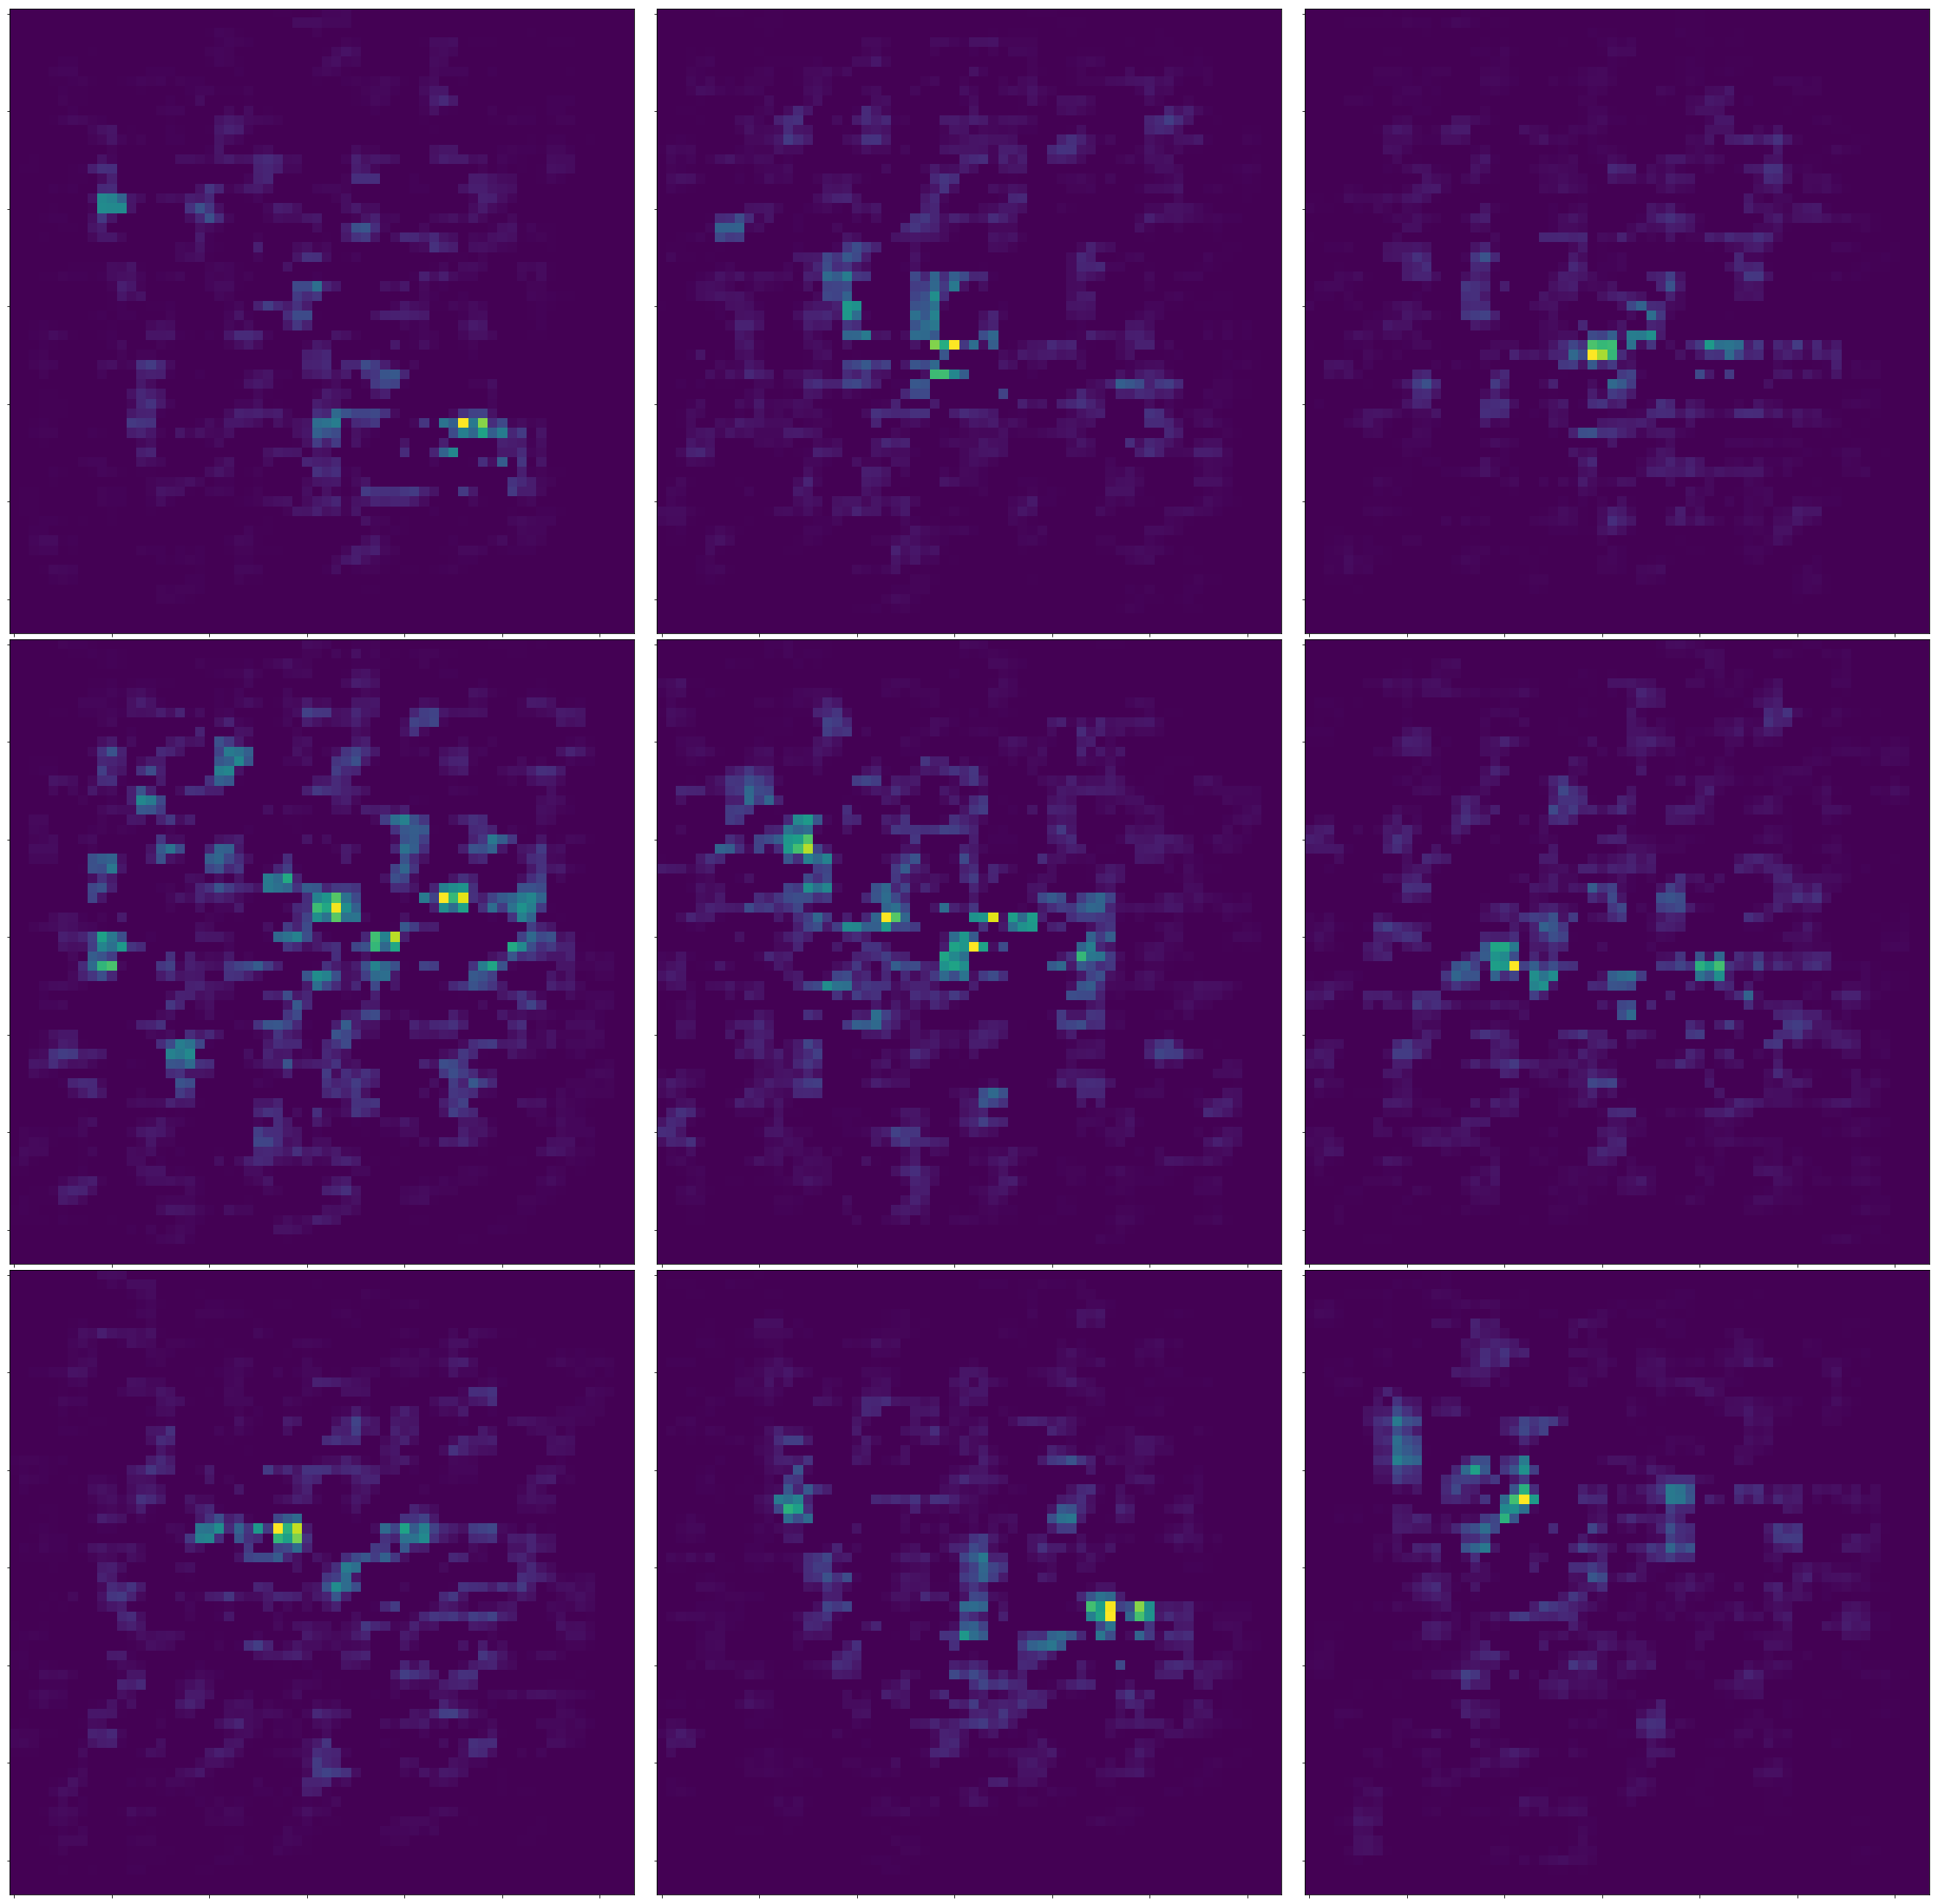

In [24]:
from vis.utils import utils #utility to find layers
from keras import activations #import activations package from keras 
from vis.visualization import visualize_saliency,visualize_cam 

layer_idx = utils.find_layer_idx(model2, 'dense_2') #We want to visualize the final dense layer. 
model2.layers[layer_idx].activation = activations.linear  
#change activation of final layer from sigmoid to linear
model2 = utils.apply_modifications(model2) #apply that modification to the model
filter_indices=0
saliency=new_images[1455:1464]
plt.rcParams["figure.figsize"] = [40,40]
plt.rcParams["axes.labelsize"] = 0
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["xtick.labeltop"]=False


i=1
d=4

for seed in saliency:
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.subplot(3,3,i)
    new_im=visualize_saliency(model2,layer_idx, filter_indices=filter_indices, seed_input=seed, backprop_modifier=None,
                          grad_modifier="relu")
    plt.imshow(new_im,cmap='viridis')
    i+=1
    if(i==10):
        break
plt.savefig('saliency_artifacts.png',bbox='tight',dpi=100)



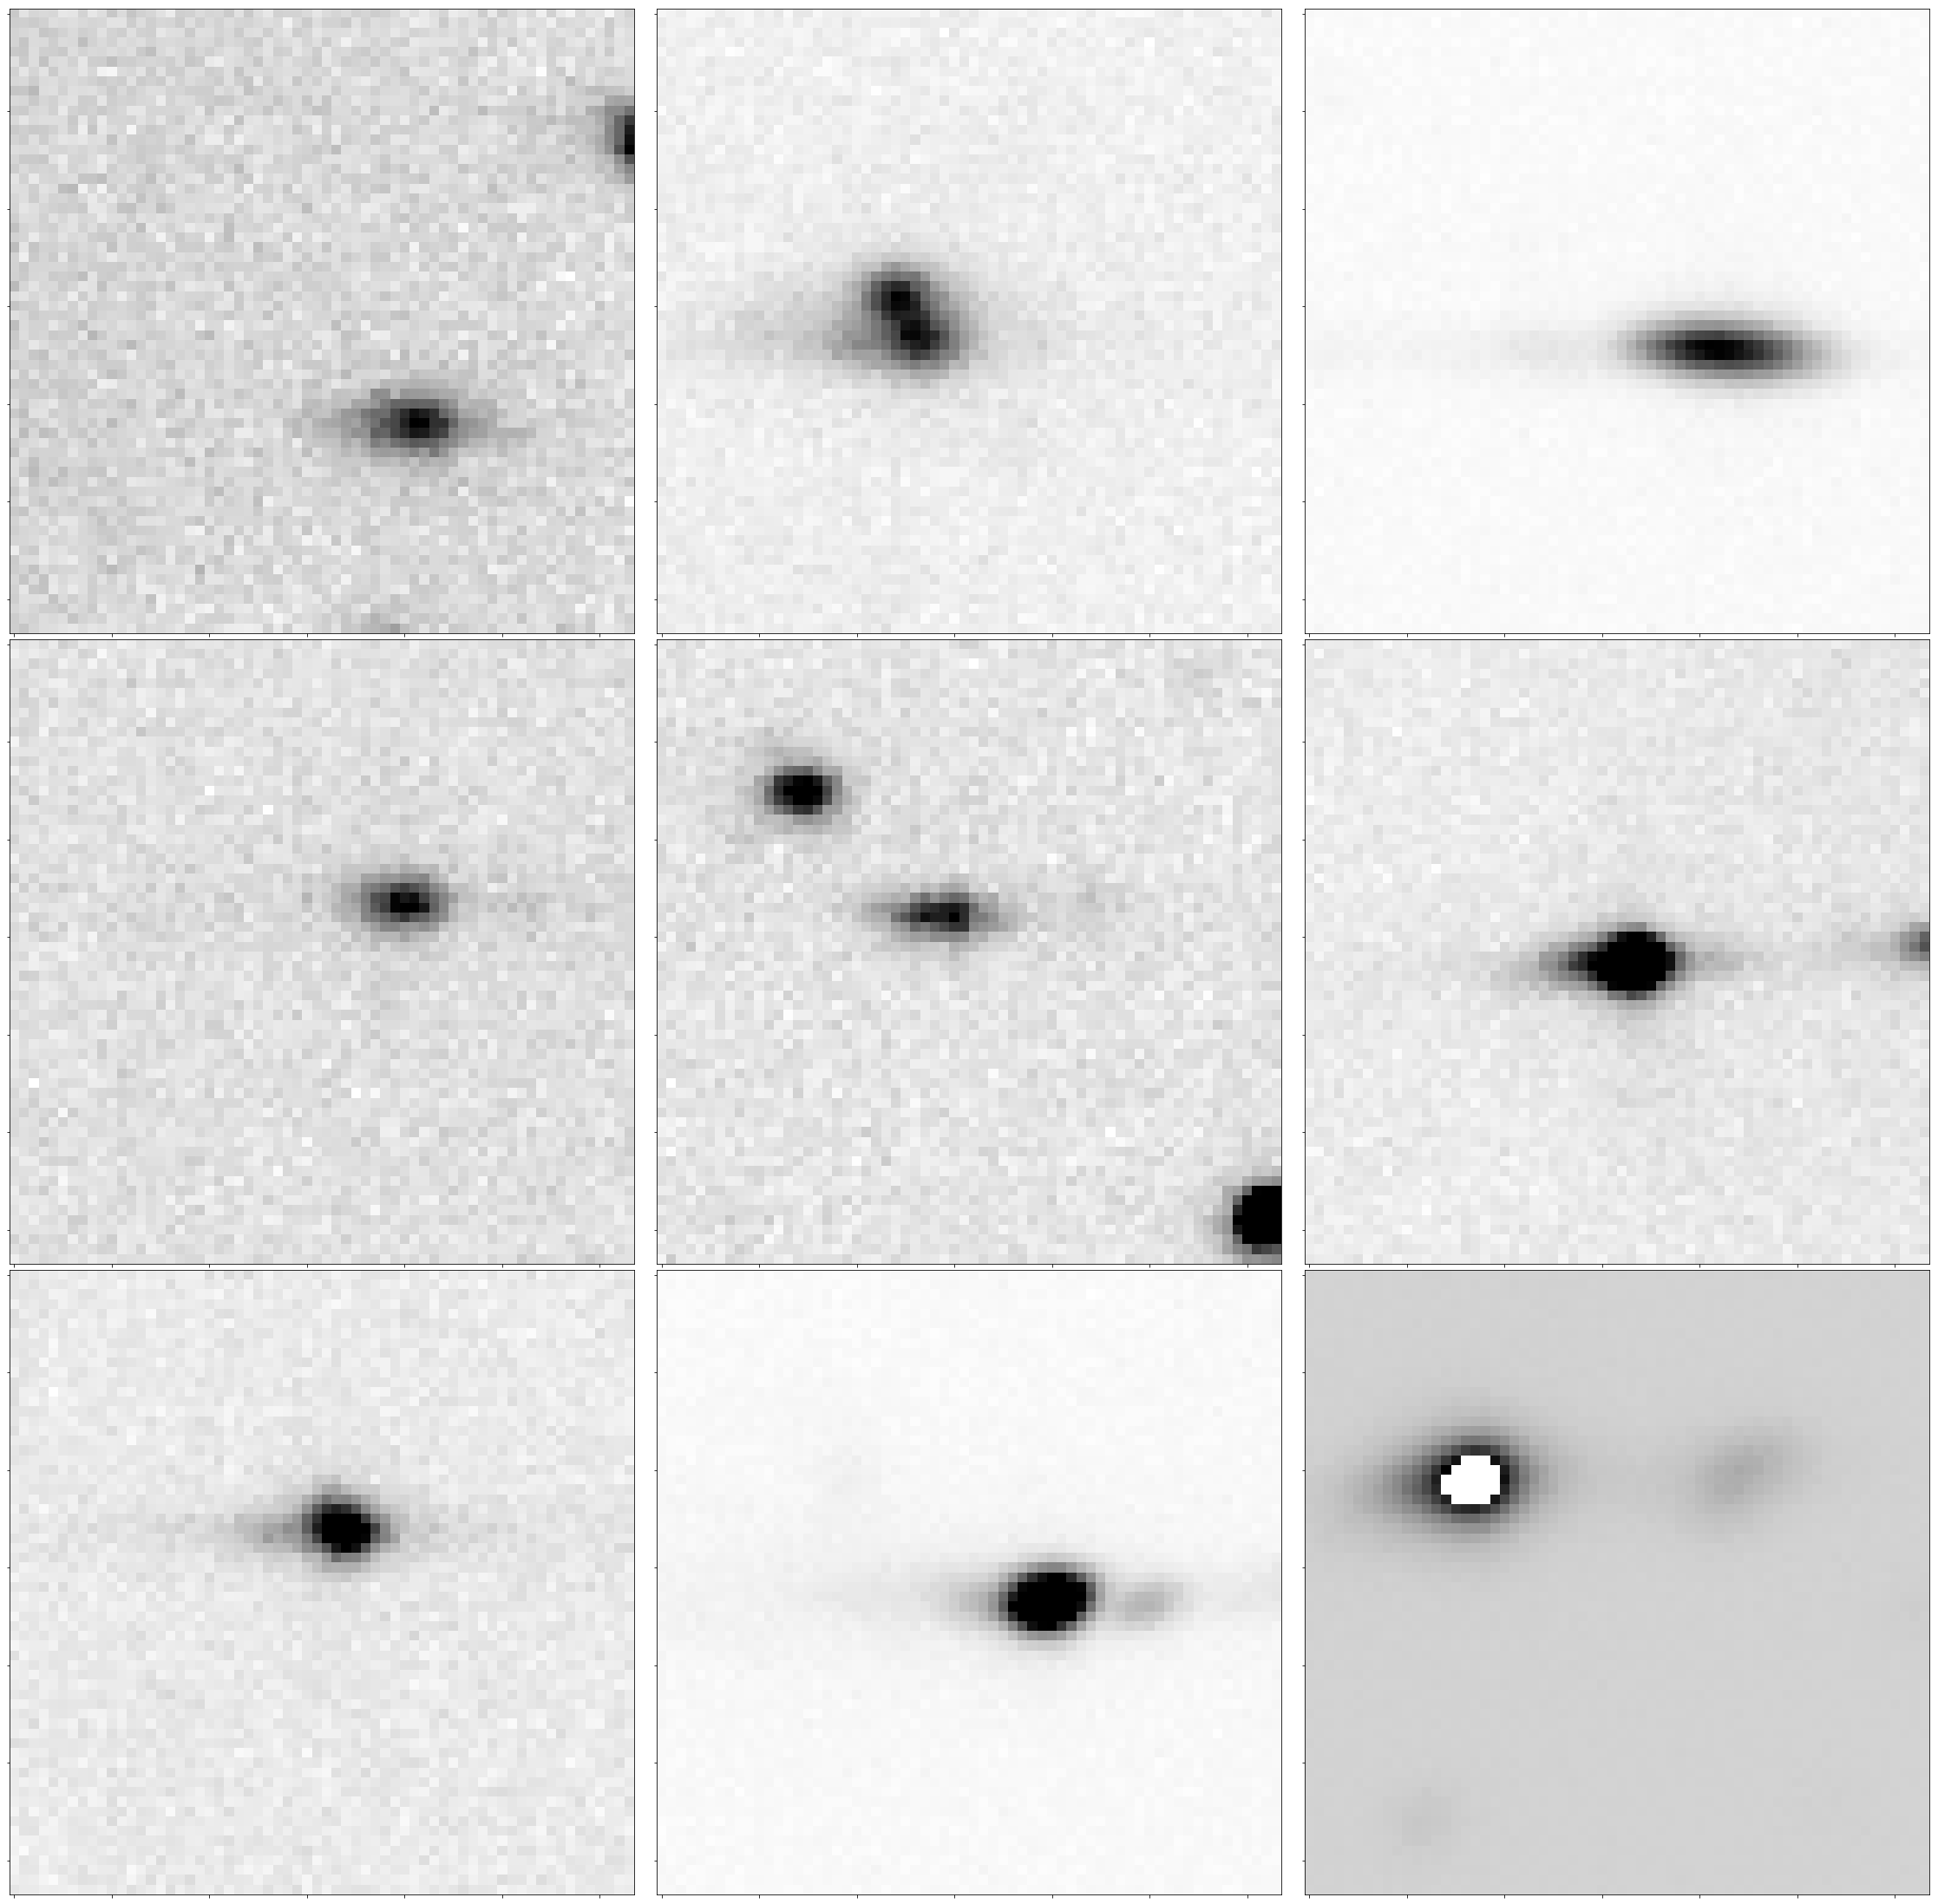

In [25]:
plt.rcParams["figure.figsize"] = [40,40]
i=1
for seed in saliency:
    temp=seed[:,:,0]
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    plt.subplot(3,3,i)
    
    #new_im=visualize_saliency(model9,layer_idx, filter_indices=filter_indices, seed_input=seed, backprop_modifier=None,
                          #grad_modifier="absolute")
    plt.imshow(temp,cmap='gray_r')
    i+=1
    if(i==10):
        break

plt.savefig('artifacts_newcollage.png',bbox='tight')

## Testing on test data sets

In [26]:
nx,ny,channels=64,64,1 #shape of input data. It is 64x64 pixels and 1 channel


images_sources=[] #empty list which will be populated with images
labels_sources=[] #empty list which will have labels.

#Labels are either 1 or 0. 1 for artifacts, 0 for stars

def read_stars(list_images): #function to generate lists of data and labels

    images_sources=[] #empty list which will be populated with images
    labels_sources=[] #empty list which will have labels.

    for img in list_images:
                    
        if 'cut_arti' in img: #if filename contains this string then append 1 to the labels list else 0
            images_sources.append(cv2.resize(cv2.imread(img, 0), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #i=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #i=np.rot90(i)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,i)
            #images.append(i)
            labels_sources.append(1)
            #labels.append(1)

        elif 'cut_star' in img:
            
            images_sources.append(cv2.resize(cv2.imread(img, 0), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #j=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #j=np.rot90(j)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,j)
            #images.append(j)
            #labels.append(0)
            labels_sources.append(0)
                        
    return images_sources,labels_sources



In [27]:
star_test = "./cutout/test/stars/"

star_test_images = ['./cutout/test/stars/{}'.format(i) for i in os.listdir(star_test) if '.png' in i]

arti_test = "./cutout/test/artifacts/"

arti_test_images = ['./cutout/test/artifacts/{}'.format(i) for i in os.listdir(arti_test) if '.png' in i]


In [28]:
test_star_images, test_star_labels = read_stars(star_test_images)

test_star_images = np.array(test_star_images).reshape(17,64,64,1)

test_star_labels = np.array(test_star_labels)
print(test_star_images.shape)

(17, 64, 64, 1)


In [29]:
test_star_generator = val_datagen.flow(test_star_images, test_star_labels, batch_size=1)
len(test_star_generator)

17

In [30]:
test_arti_images, test_arti_labels = read_stars(arti_test_images)
test_arti_images = np.array(test_arti_images).reshape(14,64,64,1)
test_arti_labels = np.array(test_arti_labels)
test_arti_generator = val_datagen.flow(test_arti_images, test_arti_labels, batch_size=1)
len(test_arti_generator)

14

## Testing on Artifacts with labels printed in title

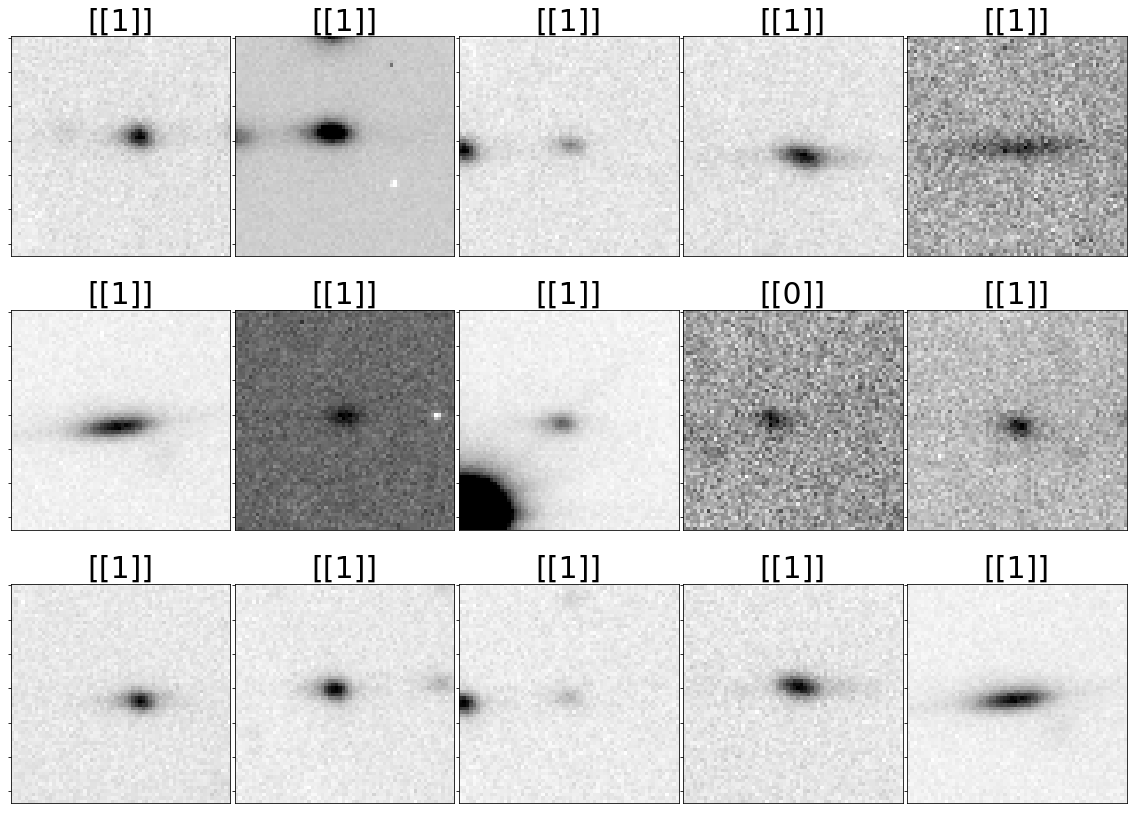

In [36]:
s=0
y_stars=[]
y_artifacts=[]
y_prob=[]
star_prob=[]
arti_prob=[]

plt.figure(figsize=(20,20))


for batch in val_datagen.flow(test_arti_images,batch_size=1):
    
    lb=model2.predict_classes(batch) #prediction labels of source
    prb = model2.predict(batch)
    
    plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)
    plt.subplots_adjust(wspace=0.02,hspace=0.03)

    if pr<0.5:
        
        plt.subplot(4,5,s+1)
        temp = np.reshape(batch[0],(64,64))

        plt.imshow(temp,cmap='gray_r')
        #per=str(round(100 - (pr[0][0]),2))+'%'
        
        plt.title(lb,fontsize=30)
        
        y_stars.append(1)
    
        y_prob.append(prb)

        plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)
        
    else:
        plt.subplot(4,5,s+1)
        temp = np.reshape(batch[0],(64,64))

        plt.imshow(temp,cmap='gray_r')
        #per=str(round((pr[0][0]),2))+'%'
        plt.title(lb,fontsize=30)
        y_prob.append(prb)
        y_stars.append(0)
        plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)

    s+=1
    if(s==15):
        break

## Testing on stars 

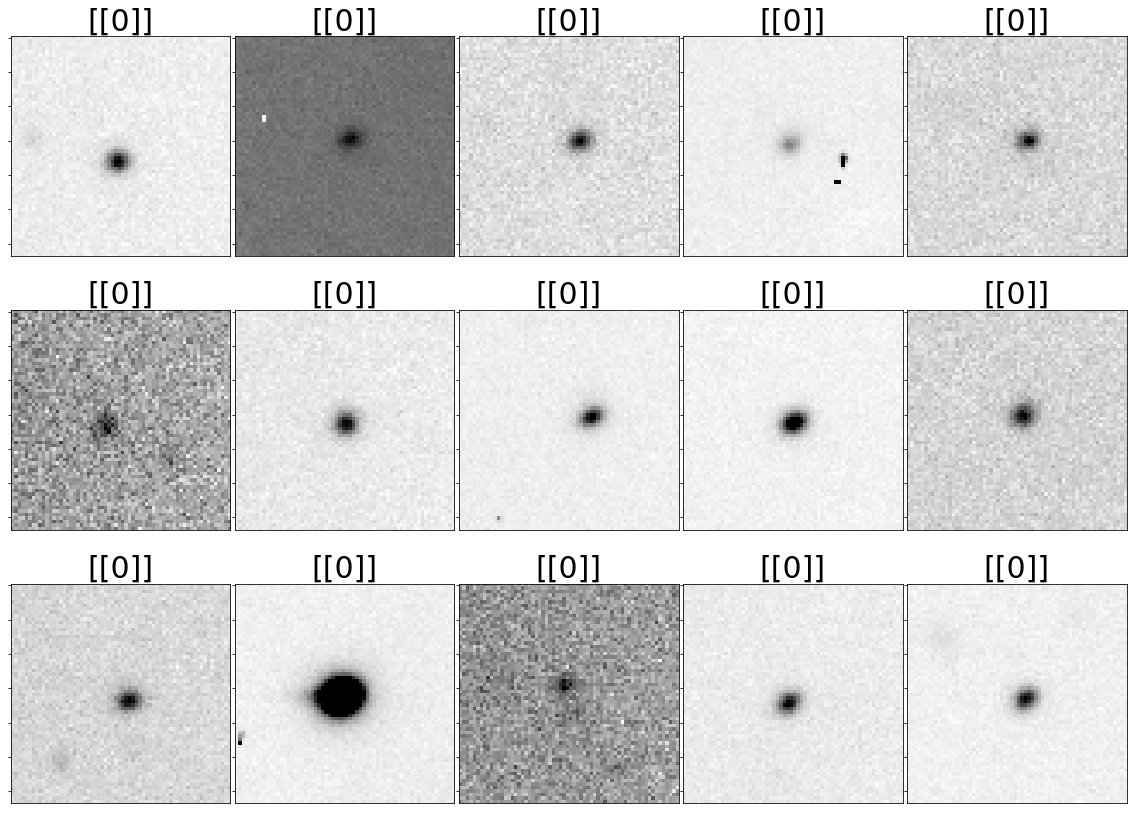

In [37]:
s=0
y_stars=[]
y_artifacts=[]
y_prob=[]
star_prob=[]
arti_prob=[]

plt.figure(figsize=(20,20))


for batch in val_datagen.flow(test_star_images,batch_size=1):
    
    lb=model2.predict_classes(batch) #prediction labels of source
    prb = model2.predict(batch)
    
    plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)
    plt.subplots_adjust(wspace=0.02,hspace=0.03)

    if pr<0.5:
        
        plt.subplot(4,5,s+1)
        temp = np.reshape(batch[0],(64,64))

        plt.imshow(temp,cmap='gray_r')
        #per=str(round(100 - (pr[0][0]),2))+'%'
        
        plt.title(lb,fontsize=30)
        
        y_stars.append(1)
    
        y_prob.append(prb)

        plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)
        
    else:
        plt.subplot(4,5,s+1)
        temp = np.reshape(batch[0],(64,64))

        plt.imshow(temp,cmap='gray_r')
        #per=str(round((pr[0][0]),2))+'%'
        plt.title(lb,fontsize=30)
        y_prob.append(prb)
        y_stars.append(0)
        plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)

    s+=1
    if(s==15):
        break

In [38]:
sources=[]
source_test_images="./testing_script/extraction/mags/"

sources=['./testing_script/extraction/mags/{}'.format(i) for i in os.listdir(source_test_images) if '.png' in i]
len(sources)

73

In [39]:
names_of_stars = []
for name in sources:
    start=name.find('cut_')
    stop=name.find('mag_')
    names_of_stars.append((name[start+12:stop]+'.fits'))

mag=[]
for s in sources:
    start=s.find('mag_')
    mag.append(float((s[start+4:-4])))
    

mag_list=np.array(mag)

source,source_labels=read_stars(sources)

source = np.array(source).reshape(73,64,64,1)
source_labels = np.array(source_labels)

source.shape
source_labels.shape

source_generator = val_datagen.flow(source, source_labels, batch_size=1)


In [40]:
print(source_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/dhruv/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


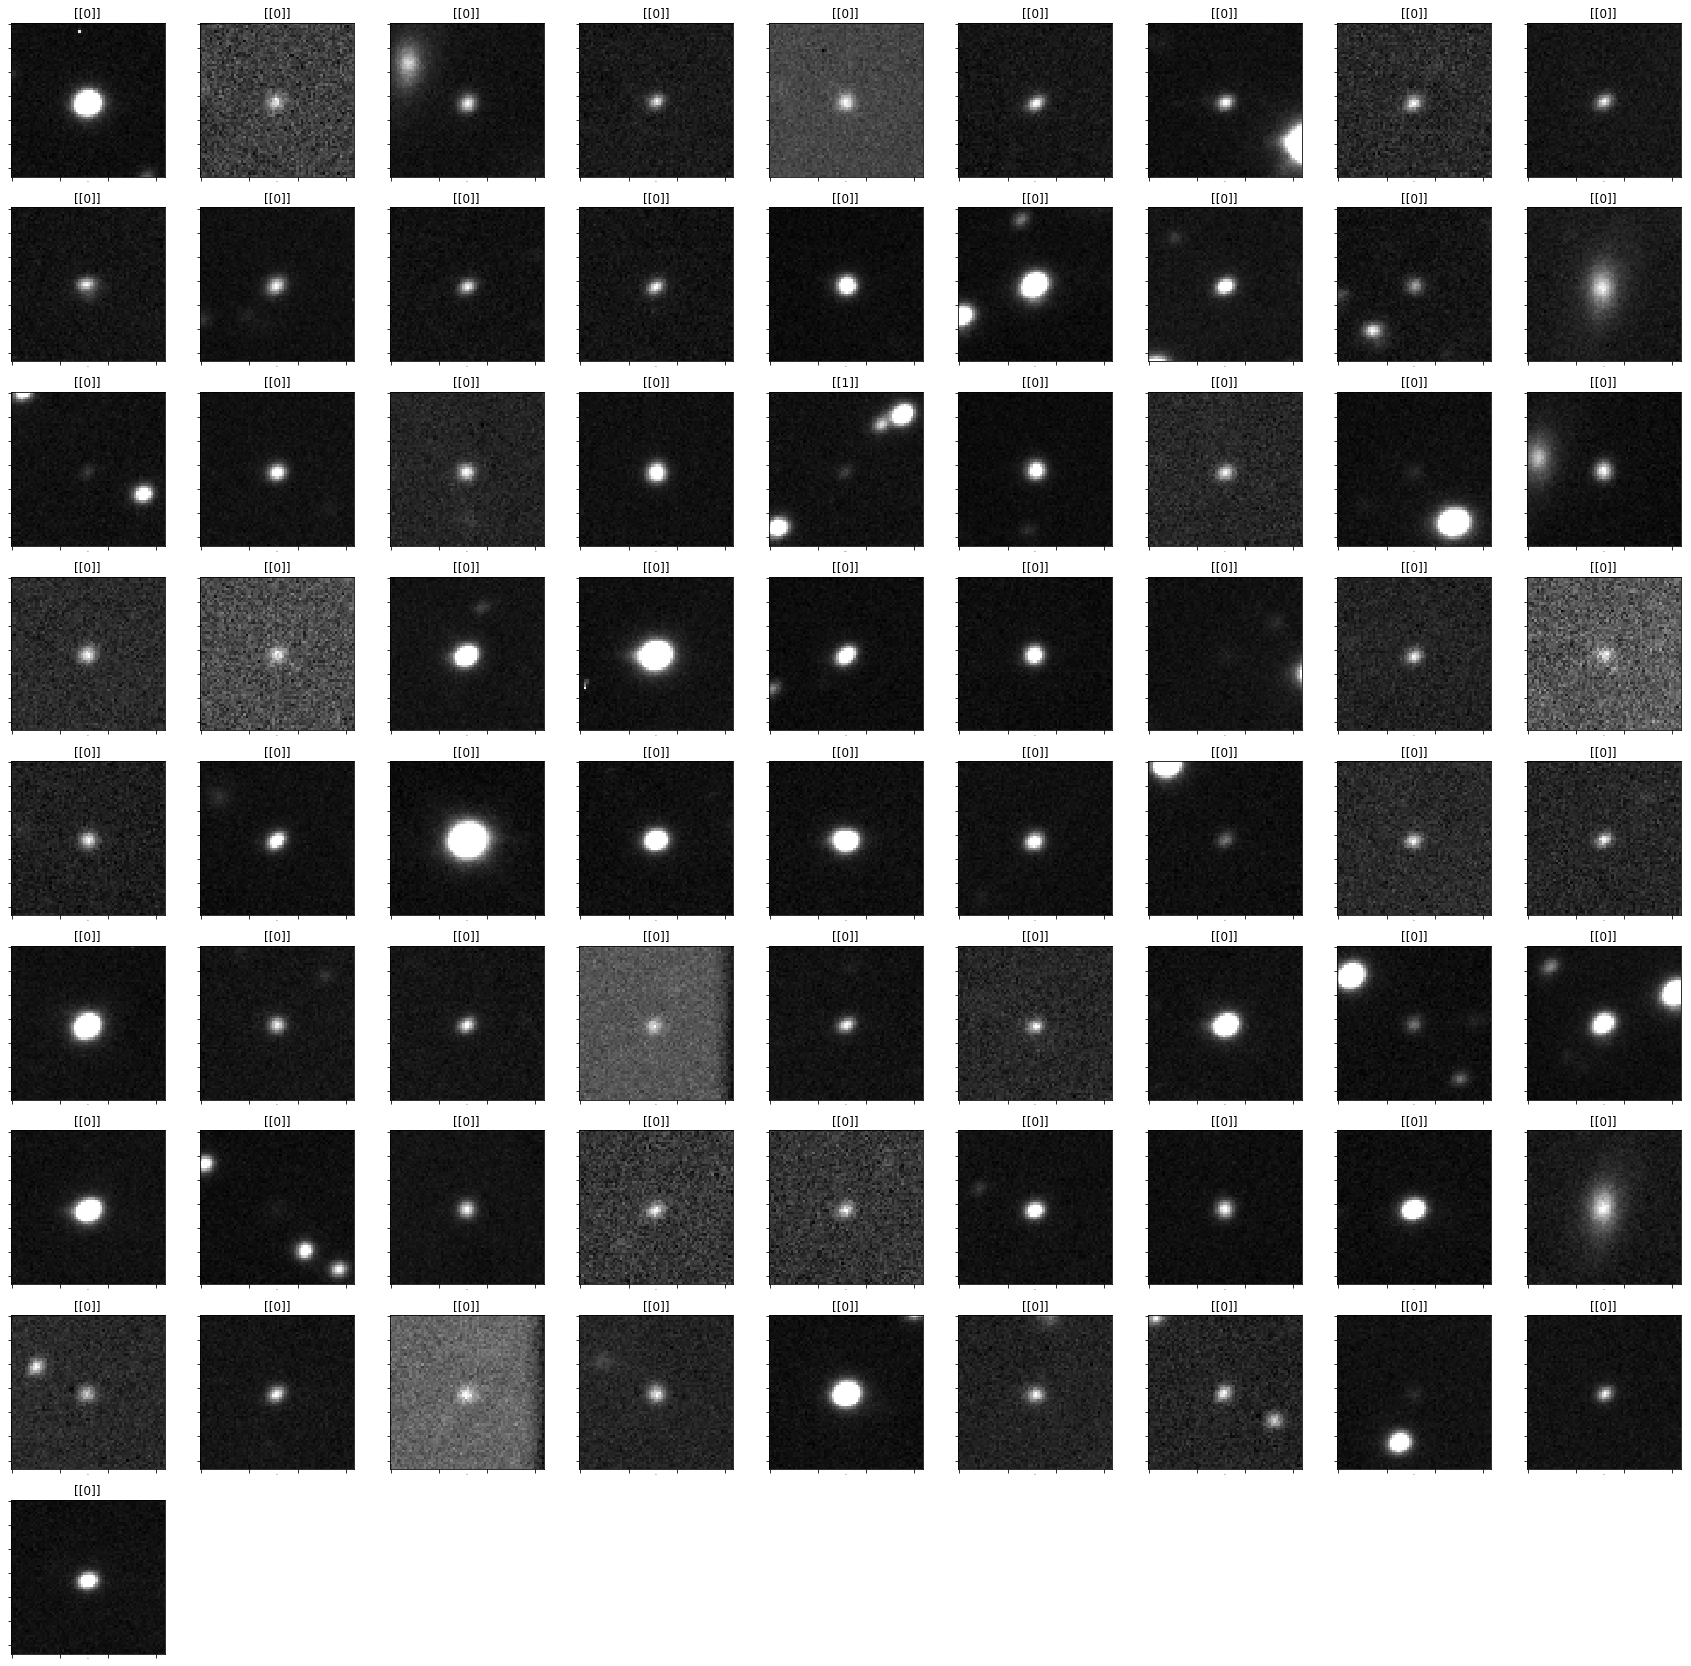

In [43]:
s=0
y_stars=[]
y_artifacts=[]
y_prob=[]
star_prob=[]
arti_prob=[]

plt.figure(figsize=(30,30))
for batch in val_datagen.flow(source,batch_size=1,shuffle=False):
    
    
    pr=model2.predict(batch)
    lab = model2.predict_classes(batch)
    if pr>0.5:
        plt.subplot(9,9,s+1)
        
        temp = np.reshape(batch[0],(64,64))
        plt.imshow(temp,cmap='gray')
        #per=str(pr*100)+'%'
        plt.title(lab)
        y_stars.append(1)
    
        y_prob.append(pr)

        plt.xlabel('artifact')
        
    else:
        
        plt.subplot(9,9,s+1)
        temp = np.reshape(batch[0],(64,64))
        plt.imshow(temp,cmap='gray')
        per=str(pr*100)+'%'
        plt.title(lab)
        plt.xlabel('star')
        y_prob.append(pr)
        y_stars.append(0)
        

    s+=1
    if(s==len(source)):
        break

## Mapping prediction probabilities and apparent magnitudes of stars in the image RBPLJ1551+5806_01_R_295.00_2014_06_01-22_36_32.fits

In [44]:
def read_stars(list_images): #function to generate lists of data and labels
    images_sources=[]
    labels_sources=[]
    for img in list_images:
        
        
                    
        if 'cut_arti' in img: #if filename contains this string then append 1 to the labels list else 0
            images_sources.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #i=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #i=np.rot90(i)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,i)
            #images.append(i)
            labels_sources.append(1)
            #labels.append(1)

        elif 'cut_star' in img:
            
            images_sources.append(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC))
            #j=(np.rot90(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (nx,ny), interpolation=cv2.INTER_CUBIC)))
            #j=np.rot90(j)
            #name=str(img[:-4])+'_rot180.png'
            #cv2.imwrite(name,j)
            #images.append(j)
            #labels.append(0)
            labels_sources.append(0)
                        
    return images_sources,labels_sources



In [45]:
sources=[]
source_test_images="./testing_script/extraction/mags/"


coord_list = []
sources=['./testing_script/extraction/mags/{}'.format(i) for i in os.listdir(source_test_images) if '.png' in i]
len(sources)

names_of_stars = []
for name in sources:
    start=name.find('cut_')
    stop=name.find('mag_')
    
    x1_start = name.find('_32_')+4
    
    x2_stop = name.find('mag_')-1
    
    coords = name[x1_start:x2_stop+1]
    
    u_index=(coords.find('_'))
    x1 = coords[0:u_index]
    x2 = coords[u_index+1:]
    coord_list.append((x1,x2))
    names_of_stars.append((name[start+12:stop]+'.fits'))

mag=[]
for s in sources:
    start=s.find('mag_')
    mag.append(float((s[start+4:-4])))
    

mag_list=np.array(mag)

len(mag_list)

source,source_labels=read_stars(sources)

source=np.array(source)
source_labels=np.array(source_labels)

source = np.array(source[:,:,:,0])
source = source.reshape(73,64,64,1)

from keras.models import load_model
model2=load_model('models/adam/model2.h5') #load model
model2.load_weights('models/adam/weights_model2.h5') #load model weights

source_generator = val_datagen.flow(source, source_labels, batch_size=1)


## Plot stars with their prediction probabilities of being stars on top of each image

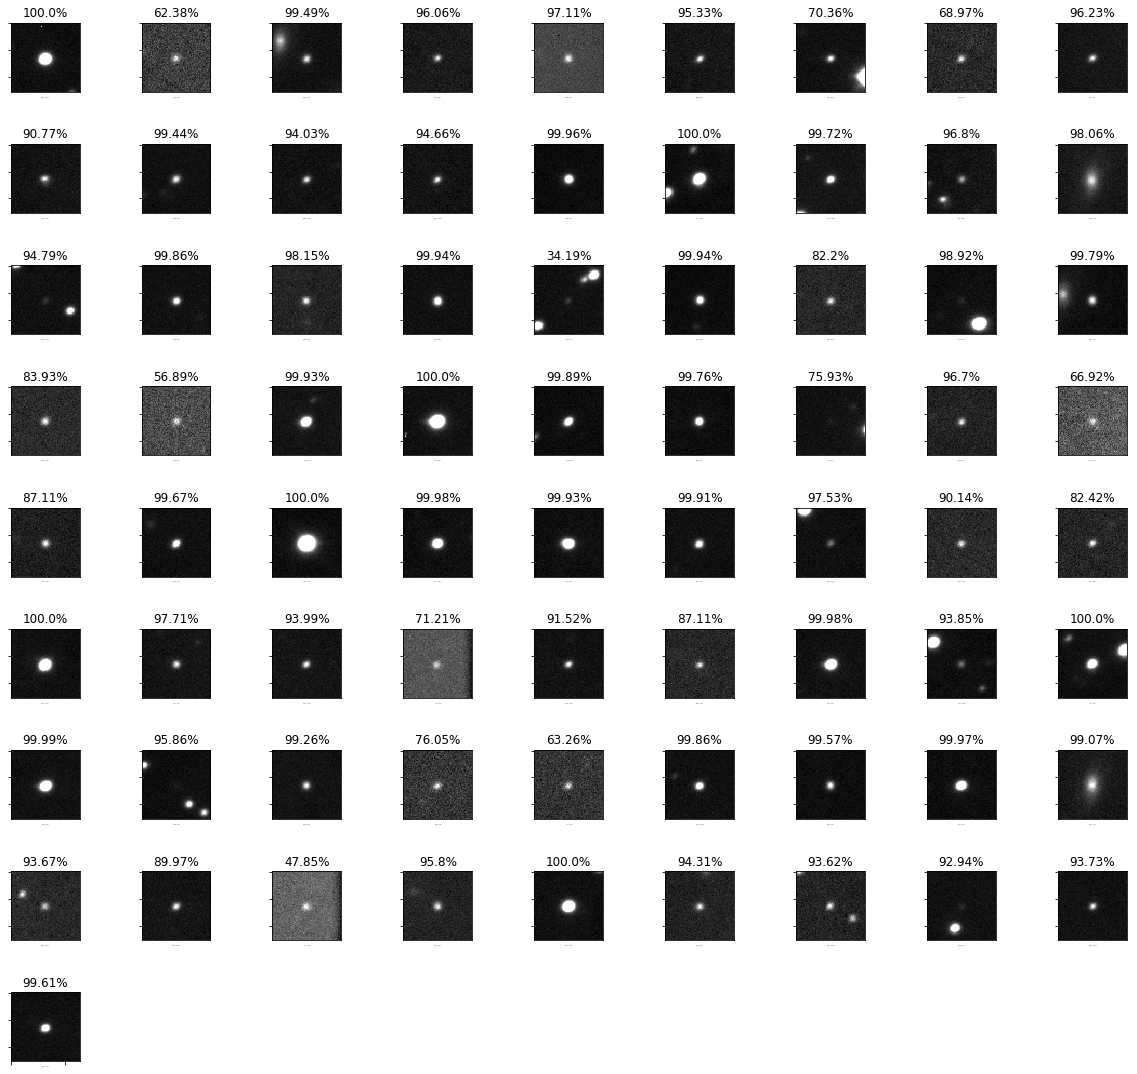

In [47]:
s=0
y_stars=[]
y_artifacts=[]
y_prob=[]
star_prob=[]
arti_prob=[]


plt.figure(figsize=(20,20))

for batch in val_datagen.flow(source,batch_size=1,shuffle=False):
    
    plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False,labelleft=False)
    plt.subplots_adjust(wspace=0.9,hspace=0.03)
   
    pr=model2.predict(batch)
    
    
    if pr>0.5:
        plt.subplot(9,9,s+1)
        plt.imshow(batch[0,:,:,0],cmap='gray')
        per=str(round(100 - pr[0][0]*100,2))+'%'
        plt.title(per)
        y_stars.append(1)
    
        y_prob.append(pr)

        plt.xlabel(str(coord_list[s]))
        #plt.xlabel('artifact')
        
    else:
        plt.subplot(9,9,s+1)
        plt.imshow(batch[0,:,:,0],cmap='gray')
        per=str(round((100 - pr[0][0]*100),2))+'%'
        plt.title(per)
        plt.xlabel(str(coord_list[s]))
        y_prob.append(pr)
        y_stars.append(0)

    s+=1
    if(s==len(source)):
        break

## Read the original file containing the coordinates of the center of the diamond pattern and the R1 Magnitudes

In [48]:
import pandas as pd
data = pd.read_csv("magnitude_mapping/csv/13_RBPLJ1551+5806_01_R_295.00_2014_06_01-22_36_3.csv",skiprows=2)

x_robo = data['# x coord']
y_robo = data[' y coord']
r1_mag = data[' Rmag1']

coord_robo = []

for i in range(len(x_robo)):
    
    x_i = int(x_robo[i])
    y_i = int(y_robo[i])
    
    to_append = '('+str(x_i)+','+str(y_i)+')'
    
    coord_robo.append(to_append)
    

## Map the actual coordinates of the stars in the images to their center and hence find their magnitudes

In [49]:

robopol_log = open('magnitude_mapping/robopol_log.txt')

search = robopol_log.readlines()

string = 'Outer diameter in pixels is 22.6'
i=0
for line in search:
    
    if string in line:
        found = i
        break
        
    i+=1


starts=[]
i=0

search_data = search[found:]

dic={}


for i,line in enumerate(search[found:]):
    
    if 'Calling calculate_pol on source' in line:
        spot0 = search[found+i+2].find('(')
        spot0 = search[found+i+2][spot0:-2]
        
        spot1 = search[found+i+4].find('(')
        spot1 = search[found+i+4][spot1:-2]
        
        spot2 = search[found+i+6].find('(')
        spot2 = search[found+i+6][spot2:-2]        
        
        
        spot3 = search[found+i+8].find('(')
        spot3 = search[found+i+8][spot3:-2]
        
        dic[spot0]=line[(line.find('(')):]
        dic[spot1]=line[(line.find('(')):]
        dic[spot2]=line[(line.find('(')):]
        dic[spot3]=line[(line.find('(')):]


        

## Make a plot of the prediction probability of a star being a star and its apparent magnitude 

In [58]:
apparent_mags = []
for num in coord_list:
    
    tup = '('+str(num[0])+','+str(num[1])+str(')')
    
    if tup in dic:
        to_find = dic[tup]
        loc_found=(coord_robo.index(to_find[:-1]))
        apparent_mags.append(r1_mag[loc_found])
    
    else:
        apparent_mags.append(0)

In [59]:
apparent_mags=np.array(apparent_mags)

In [60]:
y_prob = np.array(y_prob)

In [61]:
prediction_probs = abs(1 - np.array(y_prob[:,0,0]))

In [62]:
bad_locs = np.where(apparent_mags==0)
bad_locs[0]

array([ 1,  5,  7,  8,  9, 12, 13, 14, 16, 17, 18, 21, 22, 23, 25, 28, 29,
       33, 35, 46, 48, 51, 53, 55, 57, 62, 64, 65, 68, 70, 72])

In [63]:
final_mag = []
final_prob = []

for i in range(len(apparent_mags)):
    
    if i in bad_locs[0]:
        continue
    
    final_mag.append(apparent_mags[i])
    final_prob.append(prediction_probs[i])
    

In [64]:
final_mag=np.array(final_mag)
final_prob = np.array(final_prob)

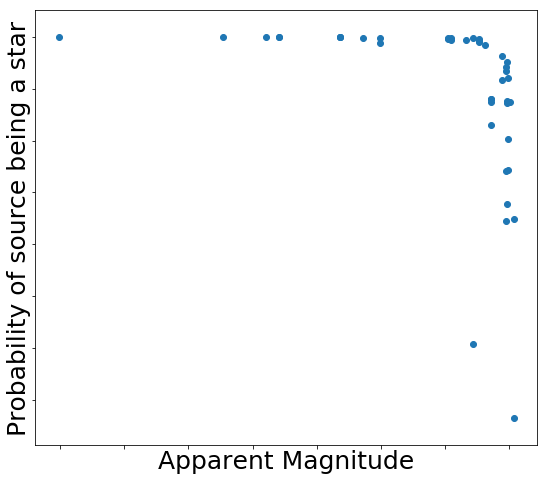

In [65]:
plt.figure(figsize=(9,8))
plt.scatter(final_mag,final_prob)
plt.xlabel('Apparent Magnitude',fontsize=25)
plt.ylabel('Probability of source being a star',fontsize=25)
plt.tick_params(axis='both',which='both',labelsize=10)

In [ ]:
plt.r